# **MACS 30112 - Final Project(American Time Use Survey Data Analysis)**

## **Tiger Parenting**

### Group Members: 
- Andy Chen
- Pritam Gajbhiye
- Cosmos
- Sania Zeb

**AI-Use Statement:**

We occasionally used AI, mainly ChatGPt, and the codes from the lecture files.<br>
Mostly, we used AI to for model and plot suggestions and rewrite variables.<br>
We also used https://stackoverflow.com/ for model and plot suggestions.<br>


### **Part 1. Library Import**

In [618]:
# import the required libraries
import geopandas as gpd
import json
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.interpolate import make_interp_spline
from scipy.stats import linregress
import seaborn as sns
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan

### **Part 2. Data Sources**

In [619]:
# import American Time Use Survey
atus_df = pd.read_csv(r'data/atussum_0322.dat')

In [620]:
# import CPS data file(geographic info for American Time Use Survey)
cps_df = pd.read_csv(r'data/atus_00002.csv')

In [621]:
# import U.S. Census state(median income level at the state level)
state_income = pd.read_csv(r'data/avg_median_income.csv')

### **Part 3. Data Wrangling**

#### **Part 3.1. American Time Use Survey(geographic information)**

In [622]:
# merge the geographic columns to the overall dataframe

cps_df.rename(columns={'CASEID': 'TUCASEID'}, inplace=True)
cps_df_subset = cps_df[['TUCASEID', 'REGION', 'STATEFIP']]

# merge cps_df_subset with atus_df on 'TUCASEID'
atus_df = atus_df.merge(cps_df_subset, on='TUCASEID', how='left')

#### **Part 3.2. American Time Use Survey**

In [623]:
# measure the shape of the dataframe
shape_of_dataframe = atus_df.shape

# Print the shape
print("American Time Use Survey has", shape_of_dataframe[0], "rows and", 
      shape_of_dataframe[1], "columns.")

American Time Use Survey has 236591 rows and 458 columns.


In [624]:
# Get the datatypes for each column in the dataframe
column_data_types = atus_df.dtypes

# Count the number of columns for each data type
data_type_counts = column_data_types.value_counts()

# The number of columns for each data type
print(data_type_counts)

int64      456
float64      2
dtype: int64


#### **Part 3.2.1. Selection criteria for the sample**

After viewing our sample:
- We restrict our sample with respondents who are parents and with a child/chlidren below the age of 18
- We restrict our sample with parents with only 3 or less children after identifying the outliers
- We restrict our sample with parents from the four highest percentage races

In [625]:
# filter out respondents without children using the variables TRYHHCHILD(the age 
# of youngest household child < 18)
# given that -1 indicates missing values, respondents with negaitve values are removed

atus_df_mod1 = atus_df[atus_df['TRYHHCHILD'] >= 0]
atus_df_mod1.shape

(103148, 458)

In [626]:
# check if the correct respondents are removed with the other variable TRCHILDNUM
# (the number of children less than the age of 18 in the household)
# after the removal, the shapes of the two datasets are identifical

atus_df_mod1_cf = atus_df[atus_df['TRCHILDNUM'] > 0]
atus_df_mod1_cf.shape

(103148, 458)

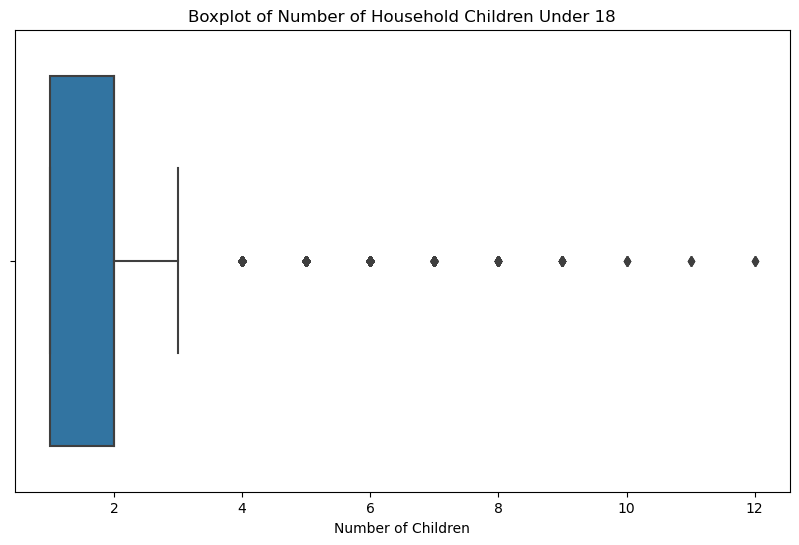

In [627]:
# using a boxplot to display the distribution and potential outliers for 
# the number of household children
plt.figure(figsize=(10, 6))
sns.boxplot(x=atus_df_mod1['TRCHILDNUM'])
plt.title('Boxplot of Number of Household Children Under 18')
plt.xlabel('Number of Children')

# display the plot
plt.show()

In [628]:
children_group_counts = atus_df_mod1['TRCHILDNUM'].value_counts().sort_index()

# display the counts for each group
print(children_group_counts)

1     42492
2     39350
3     15103
4      4505
5      1129
6       376
7       123
8        44
9        16
10        4
11        3
12        3
Name: TRCHILDNUM, dtype: int64


In [629]:
# based on the boxplot and the counts, the distribution is clustered between 
# the number 1 and 4
# we then remove respondents with chlidren greater than 4

# filter out individuals with more than 4 children in 'TRCHILDNUM'
atus_df_mod2 = atus_df_mod1[atus_df['TRCHILDNUM'] <= 4]
atus_df_mod2.shape

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/958350003.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(101450, 458)

#### **Part 3.2.2. Missing values**

- According to the codebook, missing values are coded as -1: blank, -2: don't know, -3: refused
- In addition, there may be other columns that contain negaitve values for special meanings

In [630]:
# find all unique negative values in the dataframe
negative_values = atus_df_mod2[atus_df_mod2 < 0].stack().unique()
negative_values.sort()

# print the unique negative values found in the dataframe
print("Unique negative values in the dataframe:", negative_values)

Unique negative values in the dataframe: [-4. -3. -1.]


In [631]:
# identify the columns with these values
values_to_check = [-1, -3, -4]

# initialize a dictionary to hold the counts for each value
counts = {value: (atus_df_mod2 == value).sum() for value in values_to_check}

# print the counts of -1, -3, and -4 for each column
for value, count_series in counts.items():
    print(f"Count of {value} in each column:")
    print(count_series[count_series > 0])
    print() 

Count of -1 in each column:
GEMETSTA      88205
GTMETSTA      13245
TEMJOT        28565
TESCHENR      14066
TESCHLVL      86484
TESPEMPNOT    32951
TRDPFTPT      28565
TRERNWA       36162
TRSPFTPT      47692
TUFNWGTP       3020
TEHRUSLT      28565
TU20FWGT      95056
dtype: int64

Count of -3 in each column:
TESCHENR    2
dtype: int64

Count of -4 in each column:
TEHRUSLT    3451
dtype: int64



##### **The variables with missing values**

Based on the results above, the variables that are bolden will then be removed from the dataframe.<br>
We kept the remaining variables because they may be used in our model for examining the effects of socioeconomic statues.<br> 

- **GEMETSTA: Metropolitan status (1990 definitions)**
- GTMETSTA: Metropolitan status (2000 or 2010 definitions see note) - remove 3(Not identified) and -1(blank)
- **TEMJOT: Not directly found in the provided snippet, but related variables often denote employment status.**
- TESCHENR: Edited: are you enrolled in high school college or university?
- **TESCHLVL: Edited: would that be high school college or university?**
- **TESPEMPNOT: Edited: employment status of spouse or unmarried partner**
- TRDPFTPT: Full time or part time employment status of respondent
- TRERNWA: Weekly earnings (2 implied decimals)
- TRSPFTPT: Full time or part time employment status of spouse or unmarried partner
- TRYHHCHILD: Age of youngest household child < 18
- TUFNWGTP: ATUS final weight
- TEHRUSLT: Edited: total hours usually worked per week (sum of TEHRUSL1 and TEHRUSL2) - remove -4
- **TU20FWGT: ATUS final weight with method used for 2020 pandemic**

#### **Part 3.3 Variables used for the project**

##### **Survey/Demographic/Socioeconomic variables**
**Data-related**
- TUCASEID: ATUS Case ID (14-digit identifier)
- TUYEAR: Year of diary day (year of day about which respondent was interviewed)

**Demographic**
- GTMETSTA: Metropolitan status (2000 or 2010 definitions, see note)
- PTDTRACE: Race (topcoded)
- TEAGE: Edited: age
- TESEX: Edited: sex
- TRCHILDNUM: Number of household children < 18
- TRYHHCHILD: Age of youngest household child < 18
- TRSPPRES: Presence of the respondent's spouse or unmarried partner in the household
- 'REGION': Regions that respondents live
- 'STATEFIP': States that respondents live

**Socioecnomoic**
- PEEDUCA: Edited: what is the highest level of school you have completed or the highest degree you have received?
- TELFS: Edited: labor force status
- TESCHENR: Edited: are you enrolled in high school, college, or university?
- TESCHLVL: Edited: would that be high school, college, or university?
- TESPEMPNOT: Edited: employment status of spouse or unmarried partner
- TRDPFTPT: Full time or part time employment status of respondent
- TRSPFTPT: Full time or part time employment status of spouse or unmarried partner

#### **The categories of all activities**

- t01 Personal Care Activities
- t02 Household Activities
- t03 Caring For & Helping Household Members
- t04 Caring For & Helping Nonhousehold Members
- t05 Work & Work-Related Activities
- t06 Education
- t07 Consumer Purchases
- t08 Professional & Personal Care Services
- t09 Household Services
- t10 Government Services & Civic Obligations
- t11 Eating and Drinking
- t12 Socializing, Relaxing, and Leisure
- t13 Sports, Exercise, & Recreation
- t14 Religious and Spiritual Activities
- t15 Volunteer Activities
- t16 Telephone Calls
- t18 Traveling
- TEHRUSLT: Edited: total hours usually worked per week

#### **The categories of children activities**

**Related to caring for & helping HH children**

- t030101: Physical care for household children
- t030102: Reading to/with household children
- t030103: Playing with household children, not sports
- t030104: Arts and crafts with household children
- t030105: Playing sports with household children
- t030108: Organization & planning for household children
- t030109: Looking after household children (as a primary activity)
- t030110: Attending household children's events
- t030111: Waiting for/with household children
- t030112: Picking up/dropping off household children
- t030186: Talking with/listening to household children

**Related to Children education**

- t030201: Homework (household children)
- t030202: Meetings and school conferences (household children)
- t030203: Home schooling of household children
- t030204: Waiting associated with household children's education

**Related to children's health**

- t030301: Providing medical care to household children
- t030302: Obtaining medical care for household children
- t030303: Waiting associated with household children's health

In [632]:
# Now, given that all activities are coded in a way that contains too much details, 
# we first combine these activities based on the categories provided in the codebook
# However, given that T03 includes caring for both adults and children, we will need to seperate 
# them into two sub-categories for analyzing the trade-off among different activiites in parents

# Create a copy of the dataset
atus_df_mod3 = atus_df_mod2.copy()

# Define the major categories and their prefixes
categories_prefix = {
    't01': 'Personal Care Activities',
    't02': 'Household Activities',
    #'t03': 'Caring For & Helping Household Members',
    't04': 'Caring For & Helping Nonhousehold Members',
    't05': 'Work & Work-Related Activities',
    't06': 'Education',
    't07': 'Consumer Purchases',
    't08': 'Professional & Personal Care Services',
    't09': 'Household Services',
    't10': 'Government Services & Civic Obligations',
    't11': 'Eating and Drinking',
    't12': 'Socializing, Relaxing, and Leisure',
    't13': 'Sports, Exercise, & Recreation',
    't14': 'Religious and Spiritual Activities',
    't15': 'Volunteer Activities',
    't16': 'Telephone Calls',
    't18': 'Traveling'
}

# Remove all activities with the ending of '99'
cols_to_remove = [col for col in atus_df_mod3.columns if col.endswith('99')]
atus_df_mod3.drop(columns=cols_to_remove, inplace=True)

category_sums = {}

# loop through each category and sum activities within each activity
for prefix, category_name in categories_prefix.items():
    pattern = prefix + r'\d{2}[0-8]\d$' 
    matching_columns = [col for col in atus_df_mod3.columns if re.match(pattern, col)]
    category_sums[category_name] = atus_df_mod3[matching_columns].sum(axis=1)

# summing up the total times for each category
for category_name, sums in category_sums.items():
    atus_df_mod3[category_name] = sums

activity_columns_to_drop = []
for prefix in categories_prefix.keys():
    pattern = r'^' + prefix + r'\d{2}[0-8]\d$'
    regex = re.compile(pattern)
    activity_columns_to_drop += [col for col in atus_df_mod3.columns if regex.match(col)]

# drop the individual activity columns from the dataframe
atus_df_mod3.drop(columns=activity_columns_to_drop, inplace=True)   

In [633]:
# for seperating the household child and adult activities, 
# we first get the general pattern for all activities starting with 'T03'
general_care_pattern = r't03\d{4}$'

# compile the regex pattern 
general_care_regex = re.compile(general_care_pattern)

# find all columns that match the general "T03" pattern
general_care_columns = [col for col in atus_df_mod3.columns if general_care_regex.match(col)]

# patterns for "Household Child Care" and "Household Adult Care"
child_care_pattern = r't03(01|02|03)\d{2}$'
adult_care_pattern = r't03(04|05)\d{2}$'
child_care_regex = re.compile(child_care_pattern)
adult_care_regex = re.compile(adult_care_pattern)

# find all columns that match the "Household Child Care" and "Household Adult Care" patterns
child_care_columns = [col for col in general_care_columns if child_care_regex.match(col)]
adult_care_columns = [col for col in general_care_columns if adult_care_regex.match(col)]

# sum the activities for each category and add as new columns
atus_df_mod3['Household Child Care'] = atus_df_mod3[child_care_columns].sum(axis=1)
atus_df_mod3['Household Adult Care'] = atus_df_mod3[adult_care_columns].sum(axis=1)

# drop all specific T03 activity columns, keeping only the new summary columns and other non-activity columns
atus_df_mod3.drop(columns=general_care_columns, inplace=True)

In [634]:
# as mentioned previously, we remove some columns that are not uesful for the analysis

columns_to_drop_t500 = [col for col in atus_df_mod3.columns if col.startswith('t50')]
atus_df_mod3.drop(columns=columns_to_drop_t500, inplace=True)

# list of columns to be removed
columns_to_remove = ['GEMETSTA', 'TEMJOT', 'TESCHLVL', 'TESPEMPNOT', 'TU20FWGT']
atus_df_mod3.drop(columns=columns_to_remove, inplace=True)

# verify the columns have been removed
print(atus_df_mod3.columns.tolist())

['TUCASEID', 'GTMETSTA', 'PEEDUCA', 'PEHSPNON', 'PTDTRACE', 'TEAGE', 'TELFS', 'TESCHENR', 'TESEX', 'TRCHILDNUM', 'TRDPFTPT', 'TRERNWA', 'TRHOLIDAY', 'TRSPFTPT', 'TRSPPRES', 'TRYHHCHILD', 'TUDIARYDAY', 'TUFNWGTP', 'TEHRUSLT', 'TUYEAR', 'REGION', 'STATEFIP', 'Personal Care Activities', 'Household Activities', 'Caring For & Helping Nonhousehold Members', 'Work & Work-Related Activities', 'Education', 'Consumer Purchases', 'Professional & Personal Care Services', 'Household Services', 'Government Services & Civic Obligations', 'Eating and Drinking', 'Socializing, Relaxing, and Leisure', 'Sports, Exercise, & Recreation', 'Religious and Spiritual Activities', 'Volunteer Activities', 'Telephone Calls', 'Traveling', 'Household Child Care', 'Household Adult Care']


In [635]:
# After realizing there are too many categories of education levels, we then
# combine them into four education levels: below high school, high school, 
# some college but no degree, bachelor's degree, any levels above.

# define the function to categorize education levels based on the provided ranges
def categorize_education(education_code):
    """
    Categorize education levels

    This function takes an education code and categorizes it into broader education levels.
    
    The categories are defined as follows:
    - Below High School: Education code less than 39.
    - High School: Education code equals 39.
    - Some College: Education code between 40 and 42 (inclusive).
    - Bachelor’s Degree: Education code equals 43.
    - Above Bachelor’s Degree: Education code greater than 43.

    Parameters:
    - education_code (int): The education code to be categorized.

    Returns:
    - str: The categorized education level.
    """
    if education_code < 39:
        return 'Below High School'
    elif education_code == 39:
        return 'High School'
    elif 40 <= education_code <= 42:
        return 'Some College'
    elif education_code == 43:
        return 'Bachelor’s Degree'
    else:
        return 'Above Bachelor’s Degree'

# apply the function to the 'PEEDUCA' column to create a new 'Education_Level' column
atus_df_mod3['Education_Level'] = atus_df_mod3['PEEDUCA'].apply(categorize_education)

# define the categories and their order
categories = ['Below High School', 'High School', 'Some College', 'Bachelor’s Degree', 'Above Bachelor’s Degree']
cat_type = CategoricalDtype(categories=categories, ordered=True)

# convert the 'Education_Level' column to the defined categorical type
atus_df_mod3['Education_Level'] = atus_df_mod3['Education_Level'].astype(cat_type)

In [636]:
# we then combine different types of employment statuses into two general category

# adjusted mapping dictionary based on new criteria
tel_fs_mapping = {
    1: 'Employed',  
    2: 'Employed',  
    3: 'Unemployed',  
    4: 'Unemployed', 
    5: 'Unemployed'  
}

# apply the adjusted mapping to the 'TELFS' column to create a new 'Labor_Force_Status' column
atus_df_mod3['Labor_Force_Status'] = atus_df_mod3['TELFS'].map(tel_fs_mapping)

# define the categories 
categories = ['Employed', 'Unemployed']
cat_type = CategoricalDtype(categories=categories, ordered=False)

# Convert the 'Labor_Force_Status' column to the defined categorical type
atus_df_mod3['Labor_Force_Status'] = atus_df_mod3['Labor_Force_Status'].astype(cat_type)

In [637]:
# we then group the participant into three different groups for better detecting effects
# Classification method sources: the U.S. Census Bureau's American Community Survey and the Population Estimates Program 

# Define the function to categorize age groups
def categorize_age_group(age):
    """
    Categorize age groups 

    This function takes an age and categorizes it into different age groups. 
    
    The categories are defined as follows:
    - Youth: Ages between 15 and 24 (inclusive).
    - Adults: Ages between 25 and 64 (inclusive).
    - Seniors: Ages 65 and above.

    Parameters:
    - age (int): The age to be categorized.

    Returns:
    - str: The categorized age group.
    """
    if 15 <= age <= 24:
        return 'Youth'
    elif 25 <= age <= 64:
        return 'Adults'
    elif age >= 65:
        return 'Seniors'

# Apply the function to the 'TEAGE' column to create a new 'Age_Group' column
atus_df_mod3['Age_Group'] = atus_df_mod3['TEAGE'].apply(categorize_age_group)

# Define the categories and their order for the age groups
age_categories = ['Youth', 'Adults', 'Seniors']
age_cat_type = CategoricalDtype(categories=age_categories, ordered=True)

# Convert the 'Age_Group' column to the defined categorical type
atus_df_mod3['Age_Group'] = atus_df_mod3['Age_Group'].astype(age_cat_type)

In [638]:
# we also group children of the participants into different groups for better detecting effects
# Classification method sources:American Academy of Pediatrics (AAP)and World Health Organization (WHO)

# Adjust the function to categorize based on the detailed criteria for children's ages
def categorize_children_age_group(age):
    """
    Categorize children age groups

    This function takes an age of a child and categorizes it into different age groups. 
    
    The categories are defined as follows:
    - Infants: Ages up to 1 year (inclusive).
    - Toddlers: Ages between 1 and 3 years (inclusive).
    - Preschoolers: Ages between 3 and 5 years (inclusive).
    - School-age Children: Ages between 5 and 12 years (inclusive).
    - Adolescents: Ages between 13 and 18 years (inclusive).

    Parameters:
    - age (int): The age of the child to be categorized.

    Returns:
    - str: The categorized age group of the child.
    """
    if age <= 1:
        return 'Infants'
    elif 1 < age <= 3:
        return 'Toddlers'
    elif 3 < age <= 5:
        return 'Preschoolers'
    elif 5 < age <= 12:
        return 'School-age Children'
    elif 13 <= age <= 18:
        return 'Adolescents'

# Apply the function to the 'TRYHHCHILD' column to create a new 'Children_Age_Group' column
atus_df_mod3['Children_Age_Group'] = atus_df_mod3['TRYHHCHILD'].apply(categorize_children_age_group)

# Define the categories and their order based on the detailed criteria
children_age_categories = [
    'Infants',
    'Toddlers',
    'Preschoolers',
    'School-age Children',
    'Adolescents'
]
children_age_cat_type = CategoricalDtype(categories=children_age_categories, ordered=True)

# Convert the 'Children_Age_Group' column to the defined categorical type
atus_df_mod3['Children_Age_Group'] = atus_df_mod3['Children_Age_Group'].astype(children_age_cat_type)


In [639]:
# Rename the column for race and keep only the top four races
atus_df_mod3.drop(atus_df_mod3[(atus_df_mod3['PTDTRACE'] < 1) | (atus_df_mod3['PTDTRACE'] > 4)].index, inplace=True)

# Rename the column 'PTDTRACE' to 'Race'
atus_df_mod3.rename(columns={'PTDTRACE': 'Race'}, inplace=True)

# Map the numerical values to the corresponding race categories
race_mapping = {
    1: 'White',
    2: 'Black',
    3: 'Asian',
    4: 'American Indian'
}

atus_df_mod3['Race'] = atus_df_mod3['Race'].map(race_mapping)
atus_df_mod3['Race'] = atus_df_mod3['Race'].astype('category')

In [640]:
# Map the numerical values to the corresponding gender categories
sex_mapping = {
    1: 'Male',
    2: 'Female'
}

atus_df_mod3['Sex'] = atus_df_mod3['TESEX'].map(sex_mapping).astype('category')

In [641]:
# Check for any missing values across all columns in atus_df_mod3
missing_values = atus_df_mod3.isnull().any()

# Count the number of columns that contain missing values
num_columns_with_missing_values = missing_values.sum()

# Display the results
num_columns_with_missing_values

0

In [642]:
# check again the data types after converting serveral columns
datatypes = atus_df_mod3.dtypes

# List the number of unique data types
unique_datatypes = datatypes.unique()

# Display the results
print("\nNumber of Unique Data Types:", unique_datatypes.size)
print("Unique Data Types:", unique_datatypes)


Number of Unique Data Types: 8
Unique Data Types: [dtype('int64')
 CategoricalDtype(categories=['American Indian', 'Asian', 'Black', 'White'], ordered=False)
 dtype('float64')
 CategoricalDtype(categories=['Below High School', 'High School', 'Some College',
                   'Bachelor’s Degree', 'Above Bachelor’s Degree'],
 , ordered=True)
 CategoricalDtype(categories=['Employed', 'Unemployed'], ordered=False)
 CategoricalDtype(categories=['Youth', 'Adults', 'Seniors'], ordered=True)
 CategoricalDtype(categories=['Infants', 'Toddlers', 'Preschoolers', 'School-age Children',
                   'Adolescents'],
 , ordered=True)
 CategoricalDtype(categories=['Female', 'Male'], ordered=False)]


In [643]:
# now, we combine childcare activities into broader categories and seperate them 
# into an independent dataframe

# Define the mapping of activity codes to broader categories
activity_to_category_mapping = {
    't030101': 'Direct Care',
    't030102': 'Recreational and Developmental Activities',
    't030103': 'Recreational and Developmental Activities',
    't030104': 'Recreational and Developmental Activities',
    't030105': 'Recreational and Developmental Activities',
    't030108': 'Scheduling and Transportation',
    't030109': 'Direct Care',
    't030110': 'Social and Emotional Support',
    't030111': 'Scheduling and Transportation',
    't030112': 'Scheduling and Transportation',
    't030186': 'Social and Emotional Support',
    't030201': 'Education-related Activities',
    't030202': 'Education-related Activities',
    't030203': 'Education-related Activities',
    't030204': 'Education-related Activities',
    't030301': 'Direct Care',
    't030302': 'Direct Care',
    't030303': 'Direct Care',
}

# Extract activity columns matching the care pattern and not ending with '99' from atus_df_mod2
activity_columns = [col for col in atus_df_mod2.columns if re.match('^T03', col) and not col.endswith('99')]

# Extract additional columns present in atus_df_mod3
additional_columns = [
    col for col in [
        'TUCASEID', 'GTMETSTA', 'Education_Level', 'PEHSPNON', 'Race', 'Age_Group', 
        'Labor_Force_Status', 'TESCHENR', 'Sex', 'TRCHILDNUM', 'TRDPFTPT', 'TRERNWA', 
        'TRHOLIDAY', 'TRSPFTPT', 'TRSPPRES', 'Children_Age_Group', 'TUDIARYDAY', 
        'TUFNWGTP', 'TEHRUSLT'
    ] if col in atus_df_mod3.columns
]

# Create a new DataFrame for the child-focused aggregated data
atus_df_child = atus_df_mod3[additional_columns].copy()

# Initialize category columns with zeros
for category in set(activity_to_category_mapping.values()):
    atus_df_child[category] = 0

# Aggregate activity times into their categories from atus_df_mod2
for code, category in activity_to_category_mapping.items():
    if code in atus_df_mod2.columns:
        atus_df_child[category] += atus_df_mod2[code]

atus_df_child.head()

TUCASEID  GTMETSTA          Education_Level  PEHSPNON   Race  \
1  20030100013344        -1             Some College         2  White   
3  20030100013848        -1              High School         2  Black   
4  20030100014165        -1  Above Bachelor’s Degree         2  White   
5  20030100014169        -1        Bachelor’s Degree         2  White   
6  20030100014209        -1              High School         2  White   

  Age_Group Labor_Force_Status  TESCHENR     Sex  TRCHILDNUM  ...  TRSPPRES  \
1    Adults           Employed         2  Female           2  ...         1   
3    Adults         Unemployed         2  Female           2  ...         1   
4    Adults           Employed        -1    Male           2  ...         1   
5    Adults           Employed         1  Female           1  ...         2   
6    Adults           Employed         2  Female           1  ...         1   

    Children_Age_Group  TUDIARYDAY      TUFNWGTP  TEHRUSLT  \
1              Infants           7  1.735323e+06        30   
3  School-age Children           5  6.622023e+06        -1   
4          Adolescents           5  3.068387e+06        80   
5             Toddlers           5  3.455425e+06        40   
6  School-age Children           2  1.637826e+06        52   

  Scheduling and Transportation  Recreational and Developmental Activities  \
1                           0.0                                        0.0   
3                           0.0                                        0.0   
4                           0.0                                        0.0   
5                           0.0                                      155.0   
6                          17.0                                        0.0   

   Social and Emotional Support  Direct Care  Education-related Activities  
1                           0.0         60.0                           0.0  
3                           0.0          5.0                           0.0  
4                         105.0         15.0                           0.0  
5                          40.0         50.0                           0.0  
6                           0.0         33.0                          48.0  

[5 rows x 24 columns]

### **Part 4. Data Exploration**

#### **Part 4.1. Descriptive Table of sampled parents**

In [644]:
# Table 1. Descriptive Table of sample

# When we notice that our sample is biased toward some subpopulations, we checked
# the distribution of variables, like race and empolyment rate, against the U.S. census.
# We found that the distribution of our sample is quite simliar with the U.S. census, and
# adjusting the sample, such as subsetting, may lead to the issue of not reflect the true
# pattern in reality.

# Hence, we will use the original sample for data visualization and use methods like bootstrping or
# or SMOTE in the modelling part 

# reorder the Race column
current_categories = atus_df_mod3['Race'].cat.categories
reversed_categories = current_categories[::-1]
atus_df_mod3['Race'] = atus_df_mod3['Race'].cat.reorder_categories(reversed_categories, ordered=False)

# rename columns
column_mapping = {
    'TRCHILDNUM': 'Number of Children in Household',
    'Race': 'Race',
    'Sex': 'Sex',
    'Education_Level': 'Education (highest level achieved)',
    'Labor_Force_Status': 'Employment Status',
    'Age_Group': 'Age',
    'Children_Age_Group': 'Age (Children)'
}
atus_df_mod3.rename(columns=column_mapping, inplace=True)
atus_df_child.rename(columns=column_mapping, inplace=True)


# convert to categorical types
categorical_columns = ['Sex', 'Race', 'Age', 'Age (Children)', 
                       'Number of Children in Household', 
                       'Education (highest level achieved)', 
                       'Employment Status']
for col in categorical_columns:
    atus_df_mod3[col] = atus_df_mod3[col].astype('category')

# function to calculate counts and percentages
def calc_counts_percentages(series):
    """
    Calculate counts and percentages of unique values in a Series.

    It returns a DataFrame containing two columns:
    - 'Category': Unique values from the Series.
    - 'n(%)'

    Parameters:
    - series (Series): The pandas Series for which counts and percentages are to be calculated.

    Returns:
    - DataFrame: A DataFrame containing the categories and their corresponding counts and percentages.
    """
    counts = series.value_counts(dropna=False).sort_index()
    percentages = (series.value_counts(normalize=True, dropna=False).sort_index() * 100).round(1)
    combined = counts.astype(str) + ' (' + percentages.astype(str) + '%)'
    return pd.DataFrame({'Category': counts.index, 'n(%)': combined})

# create the descriptive table
descriptive_table = pd.DataFrame()

# iterate over the variables to calculate counts and percentages
for var in categorical_columns:
    cp_df = calc_counts_percentages(atus_df_mod3[var])
    cp_df.insert(0, 'Variable', var)
    cp_df['Variable'].iloc[1:] = '' 
    descriptive_table = pd.concat([descriptive_table, cp_df], ignore_index=True)
    if var != categorical_columns[-1]:  
        spacer_df = pd.DataFrame({'Variable': '', 'Category': '', 'n(%)': ''}, index=[0])
        descriptive_table = pd.concat([descriptive_table, spacer_df], ignore_index=True)

# apply styling for the table
def style_specific_cell(val):
    """
    apply specific styling to a cell based on its value.

    Parameters:
    - val: The value of the cell.

    Returns:
    - str: A string containing CSS styles for the cell.
    """
    if val != '':
        return 'font-weight: bold; text-align: left;'
    return ''

styled_table = descriptive_table.style.hide_index() \
    .applymap(style_specific_cell, subset=['Variable']) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

styled_table

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/3888102689.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/3888102689.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/3888102689.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipy

#### **Part 4.2. Preliminary Visualization**

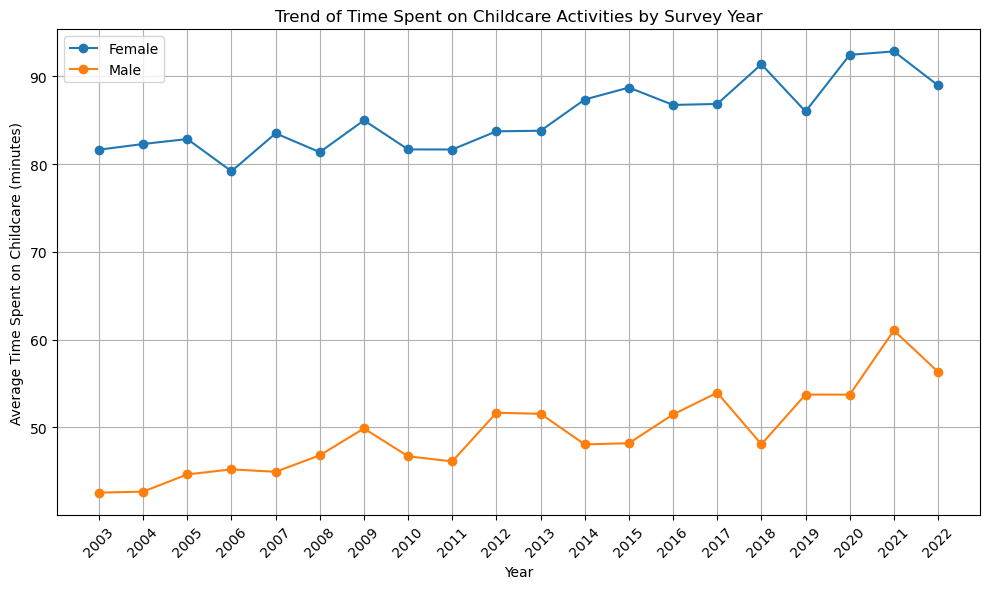

In [645]:
# exploring the gender effects on childcare
childcare_time_by_year_sex = atus_df_mod3.groupby(['TUYEAR', 'Sex'])['Household Child Care'].mean().unstack()

# plotting the trend
fig, ax = plt.subplots(figsize=(10, 6))

for sex in childcare_time_by_year_sex.columns:
    ax.plot(childcare_time_by_year_sex.index, childcare_time_by_year_sex[sex], marker='o', label=sex)

# adjust the title and the labels
ax.set_title('Trend of Time Spent on Childcare Activities by Survey Year')
ax.set_xlabel('Year')
ax.set_ylabel('Average Time Spent on Childcare (minutes)')
ax.grid(True)
ax.set_xticks(childcare_time_by_year_sex.index)
ax.set_xticklabels(childcare_time_by_year_sex.index, rotation=45) 
ax.legend()

plt.tight_layout()
plt.show()

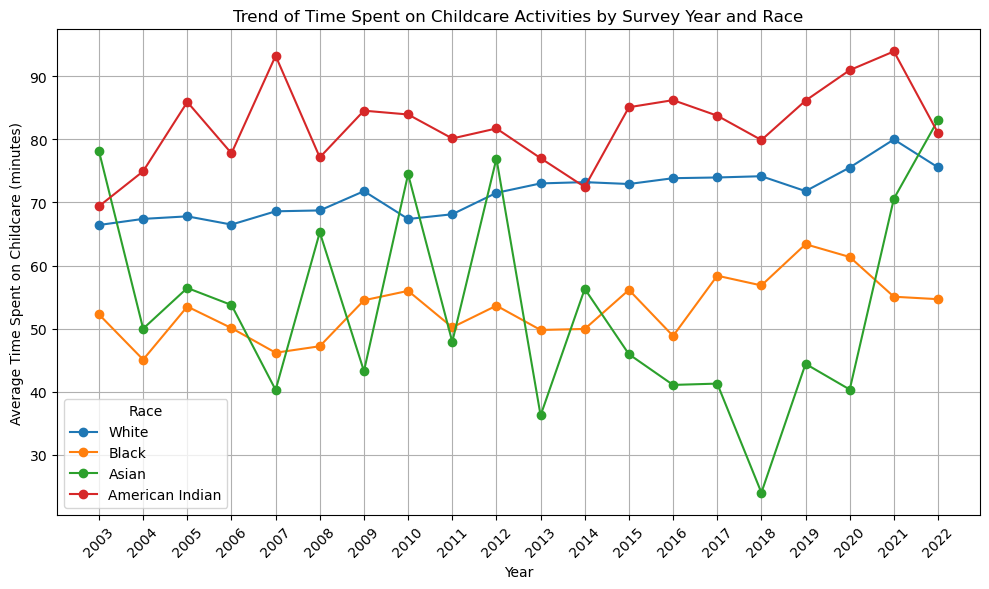

In [646]:
# exploring the effects of race on childcare
childcare_time_by_year_race = atus_df_mod3.groupby(['TUYEAR', 'Race'])['Household Child Care'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 6))

# plot the trend for each race 
for race in childcare_time_by_year_race.columns:
    ax.plot(childcare_time_by_year_race.index, childcare_time_by_year_race[race], marker='o', label=race)

# adjust the title and the labels
ax.set_title('Trend of Time Spent on Childcare Activities by Survey Year and Race')
ax.set_xlabel('Year')
ax.set_ylabel('Average Time Spent on Childcare (minutes)')
ax.legend(title='Race')
ax.grid(True)
ax.set_xticks(childcare_time_by_year_race.index)
ax.set_xticklabels(childcare_time_by_year_race.index, rotation=45)

plt.tight_layout() 
plt.show()

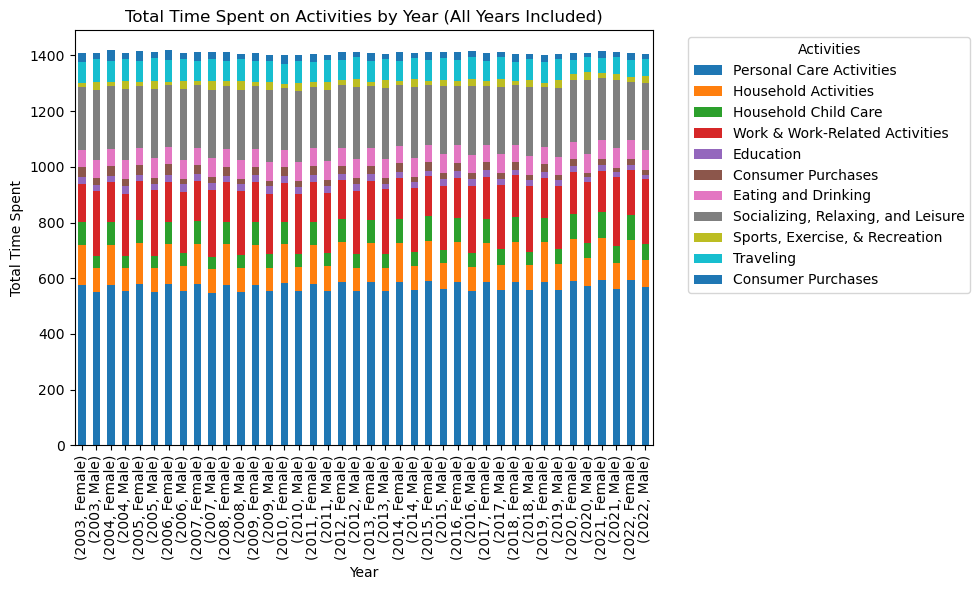

In [647]:
# exploring how the time use across all different activities
activities = ["Personal Care Activities", 
              "Household Activities", 
              'Household Child Care',
              "Work & Work-Related Activities", 
              "Education", "Consumer Purchases", 
              "Eating and Drinking",
              "Socializing, Relaxing, and Leisure", 
              "Sports, Exercise, & Recreation", 
              "Traveling",
              "Consumer Purchases"
]

pivot_df_all_years = atus_df_mod3.groupby(["TUYEAR","Sex"])[activities].mean()

# plotting for all years dynamically
pivot_df_all_years.plot(kind='bar', stacked=True,figsize=(10, 6))
plt.title("Total Time Spent on Activities by Year (All Years Included)")
plt.xlabel("Year")
plt.ylabel("Total Time Spent")
plt.legend(title="Activities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

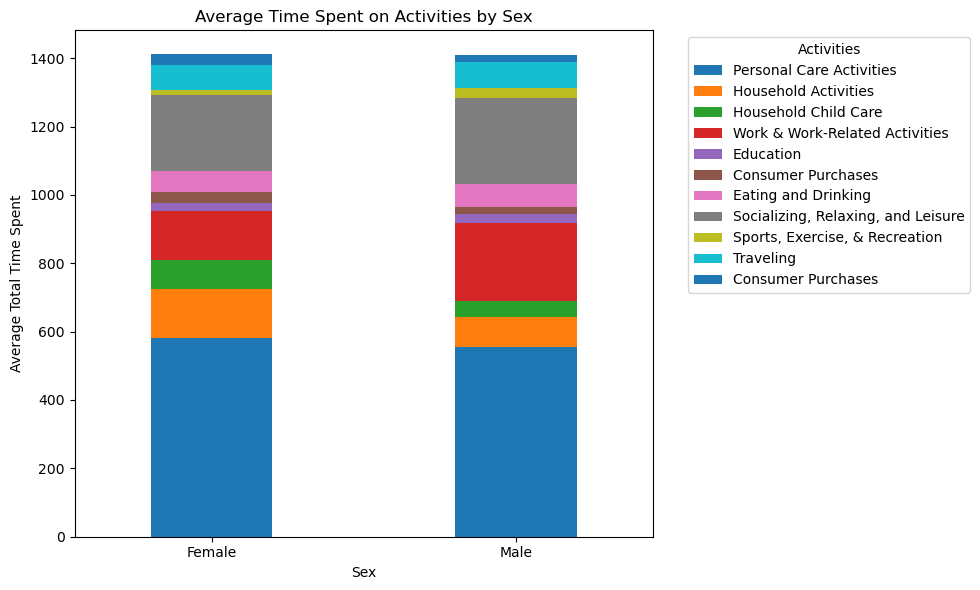

In [648]:
# exploring how the time use across all different activities and by sex

# averaging all the survey years for each sex
avg_activities_by_sex = atus_df_mod3.groupby("Sex")[activities].mean()

# plotting
fig, ax = plt.subplots(figsize=(10, 6))
avg_activities_by_sex.plot(kind='bar', stacked=True, ax=ax, width=0.4)
plt.title("Average Time Spent on Activities by Sex")
plt.xlabel("Sex")
plt.ylabel("Average Total Time Spent")
plt.legend(title="Activities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the labels for the x-axis to be horizontal.
ax.set_xticklabels(avg_activities_by_sex.index, rotation='horizontal')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

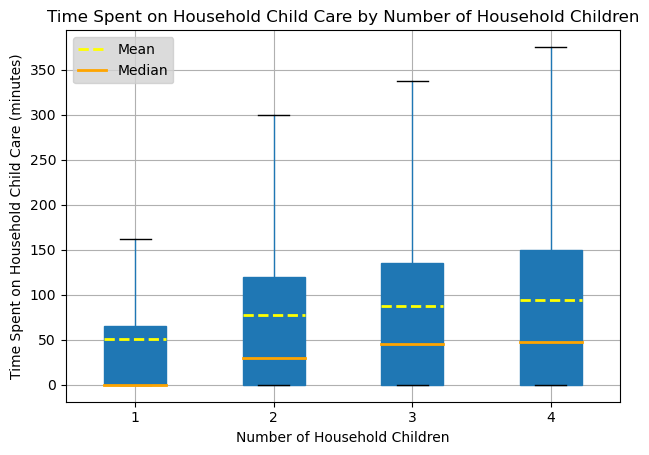

In [649]:
# exploring how time spent on childcare across household with different numbers of children
plt.figure(figsize=(10, 6))

# Plotting the boxplot with means shown as lines, without fliers (outliers)
boxplot = atus_df_mod3.boxplot(column='Household Child Care', by='Number of Children in Household',
                                showfliers=False, showmeans=True, meanline=True, patch_artist=True,
                                medianprops={'color': 'orange', 'linewidth': 2},
                                meanprops={'color': 'yellow', 'linestyle': '--', 'linewidth': 2})
plt.title('Time Spent on Household Child Care by Number of Household Children')
plt.suptitle('')  
plt.xlabel('Number of Household Children')
plt.ylabel('Time Spent on Household Child Care (minutes)')

# Create a legend for the mean and median
mean_line = plt.Line2D([], [], color='yellow', linestyle='--', linewidth=2, label='Mean')
median_line = plt.Line2D([], [], color='orange', linewidth=2, label='Median')
plt.legend(handles=[mean_line, median_line], loc='upper left', frameon=True, facecolor='lightgrey')

# Improve plot layout
plt.tight_layout()

In [650]:
# before we plot childcare on eeducation level, we first look at the distribution of the data
# we realize that the range for the time use is high and there are wide spreads
stats_table = atus_df_mod3.groupby(['Number of Children in Household', 'Education (highest level achieved)'])['Household Child Care'].describe()

# Including additional statistics - 95th percentile
stats_table['95th Percentile'] = atus_df_mod3.groupby(['Number of Children in Household', 'Education (highest level achieved)'])['Household Child Care'].quantile(0.95)

# Calculate range
stats_table['Range'] = atus_df_mod3.groupby(['Number of Children in Household', 'Education (highest level achieved)'])['Household Child Care'].max() - atus_df_mod3.groupby(['Number of Children in Household', 'Education (highest level achieved)'])['Household Child Care'].min()

# Resetting index to make 'Education_Level' and 'TRCHILDNUM' columns
stats_table.reset_index(inplace=True)

# Rename columns for clarity
stats_table.rename(columns={'TRCHILDNUM': 'Number of Household Children'}, inplace=True)

stats_table

Number of Children in Household Education (highest level achieved)  \
0                                1                  Below High School   
1                                1                        High School   
2                                1                       Some College   
3                                1                  Bachelor’s Degree   
4                                1            Above Bachelor’s Degree   
5                                2                  Below High School   
6                                2                        High School   
7                                2                       Some College   
8                                2                  Bachelor’s Degree   
9                                2            Above Bachelor’s Degree   
10                               3                  Below High School   
11                               3                        High School   
12                               3                       Some College   
13                               3                  Bachelor’s Degree   
14                               3            Above Bachelor’s Degree   
15                               4                  Below High School   
16                               4                        High School   
17                               4                       Some College   
18                               4                  Bachelor’s Degree   
19                               4            Above Bachelor’s Degree   

      count        mean         std  min   25%    50%    75%     max  \
0    7354.0   16.386456   57.080305  0.0   0.0    0.0    0.0   840.0   
1    9759.0   44.148786   88.926532  0.0   0.0    0.0   55.0  1151.0   
2   11191.0   50.671432   90.442868  0.0   0.0    2.0   65.0   960.0   
3    8380.0   74.166348  108.073059  0.0   0.0   30.0  110.0  1140.0   
4    5014.0   79.821300  110.411153  0.0   0.0   35.0  120.0  1255.0   
5    6242.0   32.506248   81.819664  0.0   0.0    0.0   11.0  1045.0   
6    7924.0   69.343892  103.627703  0.0   0.0   21.5  105.0  1055.0   
7    9575.0   78.574621  107.674206  0.0   0.0   35.0  120.0  1050.0   
8    9185.0   99.296462  115.778496  0.0   2.0   60.0  150.0  1010.0   
9    5775.0  103.102338  120.778376  0.0  10.0   62.0  150.0   985.0   
10   3378.0   43.755477   90.049472  0.0   0.0    0.0   45.0   795.0   
11   3142.0   90.147040  119.472882  0.0   0.0   45.0  135.0   885.0   
12   3478.0   95.722254  117.682816  0.0   0.0   60.0  145.0   920.0   
13   3046.0  110.528562  122.622797  0.0  15.0   75.0  165.0  1020.0   
14   1776.0  114.883446  120.751200  0.0  20.0   85.0  167.0   945.0   
15   1285.0   51.934630   96.752859  0.0   0.0    0.0   60.0   700.0   
16    981.0   92.272171  116.380623  0.0   0.0   50.0  149.0   725.0   
17   1066.0  109.767355  123.503840  0.0   1.0   66.5  175.0   703.0   
18    694.0  134.553314  127.410312  0.0  30.0  104.0  206.0   696.0   
19    382.0  119.363874  120.807133  0.0  25.0   83.0  183.0   546.0   

    95th Percentile  Range  
0            117.35    840  
1            221.10   1151  
2            240.00    960  
3            300.00   1140  
4            309.35   1255  
5            195.00   1045  
6            280.00   1055  
7            300.00   1050  
8            335.00   1010  
9            345.00    985  
10           238.00    795  
11           329.95    885  
12           330.00    920  
13           355.75   1020  
14           350.25    945  
15           270.00    700  
16           345.00    725  
17           365.00    703  
18           390.00    696  
19           364.75    546

/Users/lijiayu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



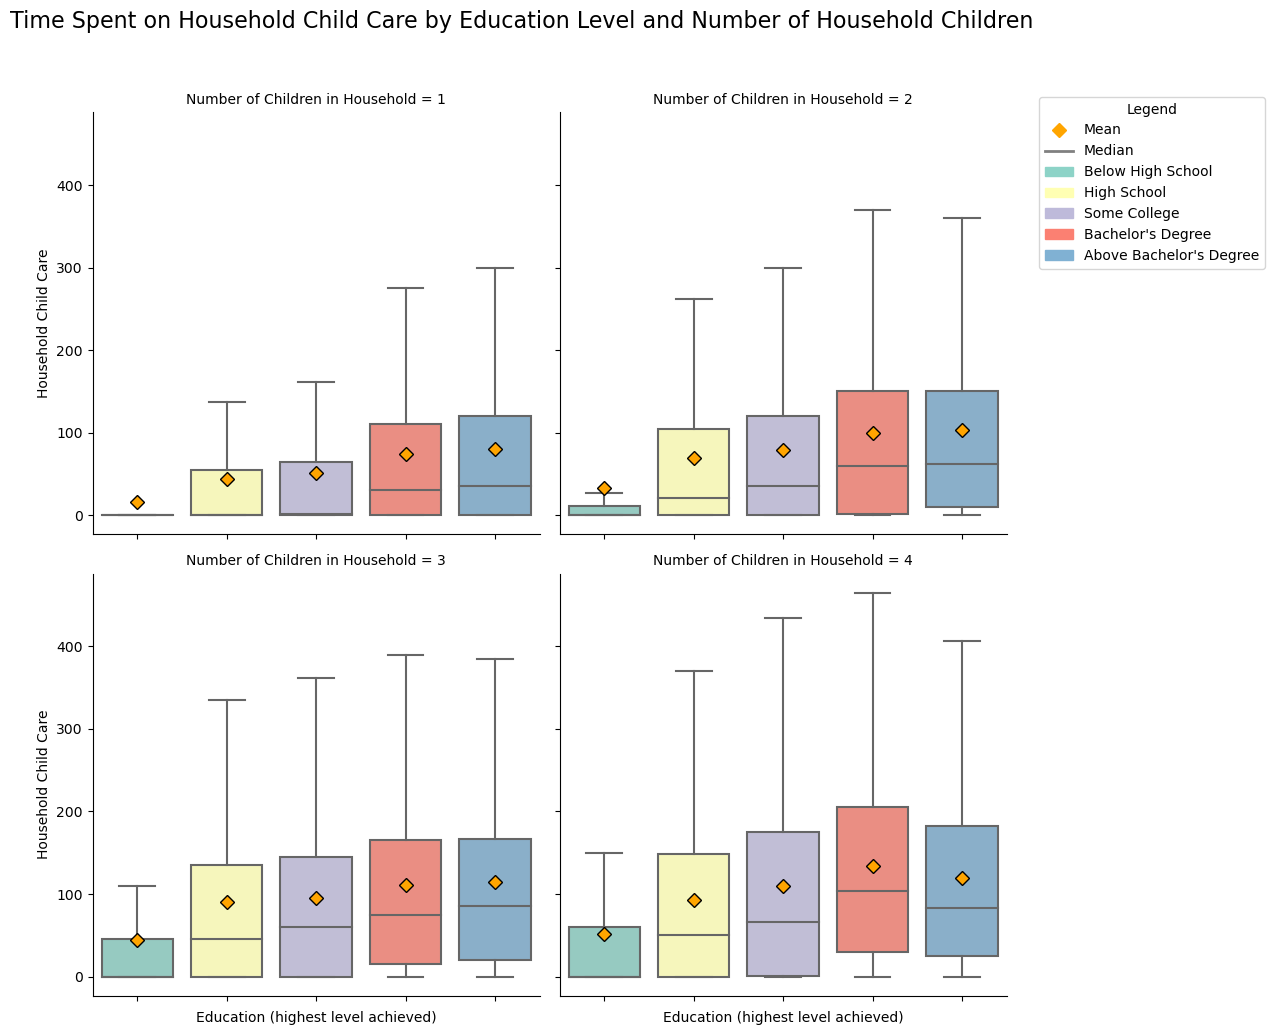

In [651]:
# we then remove the outliers in the plot and confirm the education effect is robust
# across household with different numbers of children before making the final plot

# set up a FacetGrid using the 'Number of Children in Household' as the col (column) variable
g = sns.FacetGrid(atus_df_mod3, col='Number of Children in Household', col_wrap=2, height=5)

# customizing the mean marker
meanprops = {"marker":"D", "markerfacecolor":"orange", "markeredgecolor":"black", "markersize": 7}

# map the sns.boxplot to each facet
box = g.map(sns.boxplot, 'Education (highest level achieved)', 'Household Child Care', showfliers=False, showmeans=True, meanprops=meanprops, palette='Set3')

# add titles and adjust margins for better layout
g.fig.suptitle('Time Spent on Household Child Care by Education Level and Number of Household Children', fontsize=16, y=1.03)

# rotate x-axis labels
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# creating custom legend items for mean and median
mean_legend = mlines.Line2D([], [], color='orange', marker='D', linestyle='None', markersize=7, label='Mean')
median_legend = mlines.Line2D([], [], color='gray', linestyle='-', linewidth=2, label='Median')

# the colors in the boxplot correspond to the education levels in the order they appear
education_levels = ['Below High School', 'High School', 'Some College', 'Bachelor\'s Degree', 'Above Bachelor\'s Degree']
palette = sns.color_palette('Set3', n_colors=len(education_levels))

# create a patch for each education level with the corresponding color
color_legend = [mpatches.Patch(color=palette[i], label=education_levels[i]) for i in range(len(education_levels))]

# combine the custom mean/median handles with the color legend handles
handles = [mean_legend, median_legend] + color_legend

# place the combined legend on the upper right outside the plot
g.fig.legend(handles=handles, title='Legend', loc='upper right', bbox_to_anchor=(1.25, 0.95), bbox_transform=plt.gcf().transFigure)

g.fig.tight_layout()
plt.show()

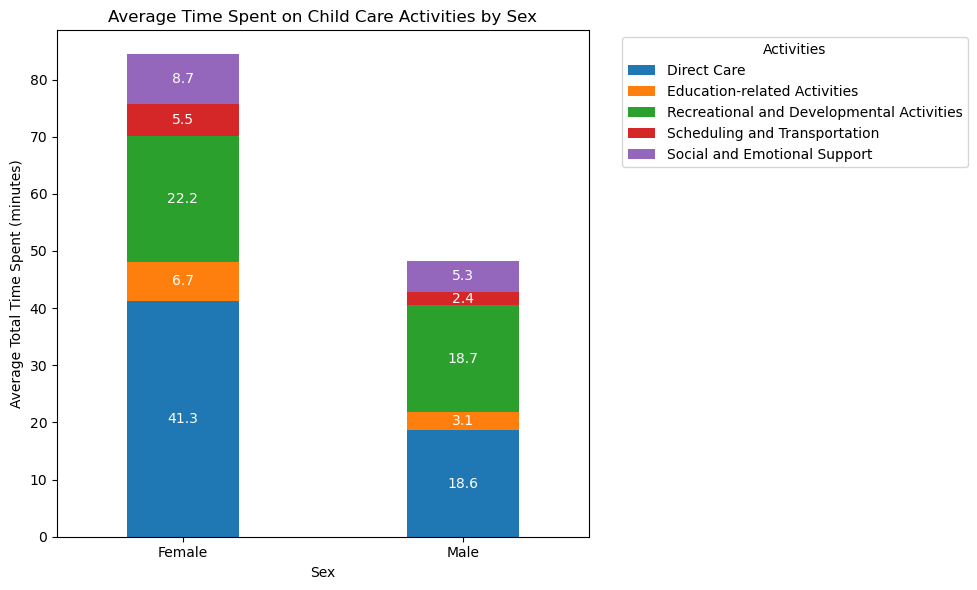

In [652]:
# we then explore how mothers and fathers spend childcare time differently

# define the categories for child care activities
categories = [
    "Direct Care", 
    "Education-related Activities", 
    "Recreational and Developmental Activities", 
    "Scheduling and Transportation", 
    "Social and Emotional Support"
]

avg_activities_by_sex = atus_df_child.groupby("Sex")[categories].mean()
fig, ax = plt.subplots(figsize=(10, 6))

# plotting the stacked bar plot
avg_activities_by_sex.plot(kind='bar', stacked=True, ax=ax, width=0.4, 
                           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title("Average Time Spent on Child Care Activities by Sex")
plt.xlabel("Sex")
plt.ylabel("Average Total Time Spent (minutes)")
plt.legend(title="Activities", bbox_to_anchor=(1.05, 1), loc='upper left', labels=categories)

# set the labels for the x-axis to be horizontal.
ax.set_xticklabels(avg_activities_by_sex.index, rotation='horizontal')

# adding labels for each segment in the stacked bar
for i, (sex, row) in enumerate(avg_activities_by_sex.iterrows()):
    cumulative_height = 0
    for category in categories:
        value = row[category]
        if value > 0: 
            ax.text(i, cumulative_height + value/2, f'{value:.1f}', ha='center', va='center', color='white')
        cumulative_height += value

plt.tight_layout()
plt.show()


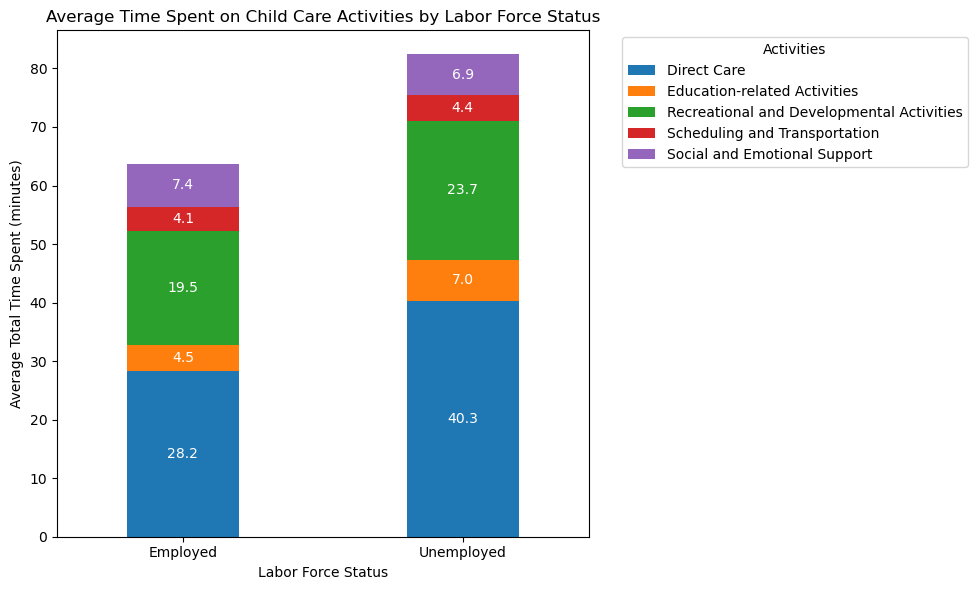

In [653]:
# we then explore how parents with different employment status spend childcare time differently
avg_activities_by_status = atus_df_child.groupby("Employment Status")[categories].mean()
fig, ax = plt.subplots(figsize=(10, 6))

# plotting the stacked bar plot
avg_activities_by_status.plot(kind='bar', stacked=True, ax=ax, width=0.4, 
                              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title("Average Time Spent on Child Care Activities by Labor Force Status")
plt.xlabel("Labor Force Status")
plt.ylabel("Average Total Time Spent (minutes)")
plt.legend(title="Activities", bbox_to_anchor=(1.05, 1), loc='upper left', labels=categories)

# set the labels for the x-axis to be horizontal.
ax.set_xticklabels(avg_activities_by_status.index, rotation='horizontal')

# adding labels for each segment in the stacked bar
for i, (status, row) in enumerate(avg_activities_by_status.iterrows()):
    cumulative_height = 0
    for category in categories:
        value = row[category]
        if value > 0: 
            ax.text(i, cumulative_height + value/2, f'{value:.1f}', 
                    ha='center', va='center', color='white')
        cumulative_height += value

plt.tight_layout()
plt.show()

#### **Part 5. Data Visualization**

##### **Figure 1. Trend of Time Spent on Childcare Activities by survey year**

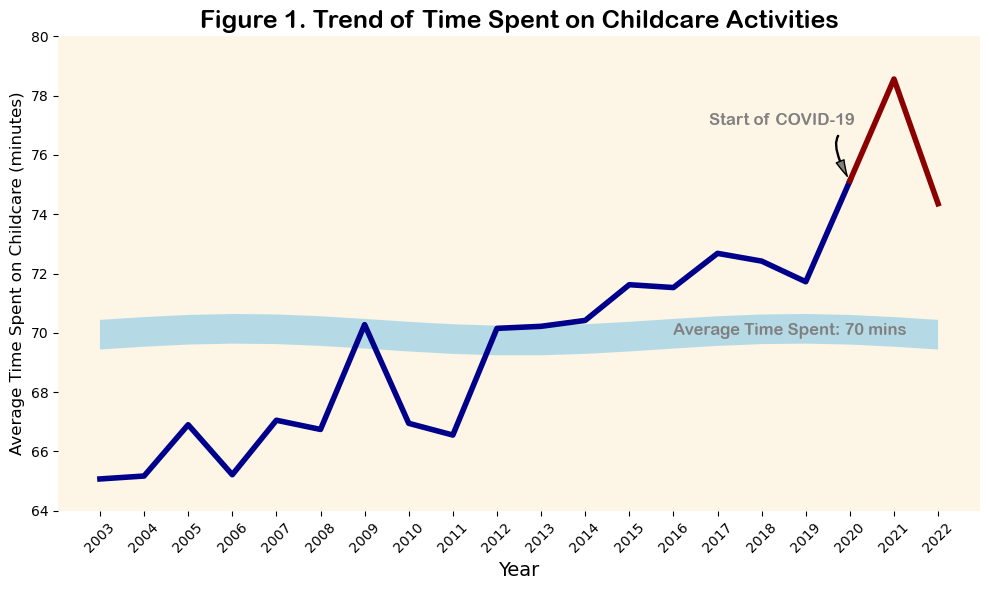

In [654]:
# Figure 1. Trend of Time Spent on Childcare Activities by survey year(final version)

# calculate the overall average and bounds
childcare_time_by_year = atus_df_mod3.groupby('TUYEAR')['Household Child Care'].mean()
overall_average = childcare_time_by_year.mean()
y_upper_bound = overall_average + 0.5
y_lower_bound = overall_average - 0.5
x = atus_df_mod3['TUYEAR']

# plot the trend without markers and with different colors for pre- and post-COVID data
pre_covid_data = childcare_time_by_year.loc[:2020]
post_covid_data = childcare_time_by_year.loc[2020:]

# altering the background and the size of the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor('oldlace')

# plot pre/post COVID trend
plt.plot(pre_covid_data.index, pre_covid_data.values, linestyle='-',linewidth=4, color='darkblue', label='Pre-COVID Trend')
plt.plot(post_covid_data.index, post_covid_data.values, linestyle='-', linewidth=4, color='darkred', label='Post-COVID Trend')

# annotation for the start of COVID-19
plt.annotate('Start of COVID-19', xy=(2020, pre_covid_data.loc[2020]), 
             xytext=(2016.8, 77), 
             color='gray',
             fontsize = 12,
             fontweight='bold', 
             fontname='Arial Rounded MT Bold',
             arrowprops=dict(facecolor='gray', 
                             shrink=0.1, 
                             width=0.7, 
                             headwidth=6, 
                             connectionstyle="angle3,angleA=0,angleB=- 60"))  

# create a wavy pattern
wave_amplitude = 0.2  
wave_frequency = 3  

y2 = y_upper_bound + wave_amplitude * np.sin(wave_frequency * np.pi * (x - x.min()) / (x.max() - x.min()))
y1 = y_lower_bound + wave_amplitude * np.sin(wave_frequency * np.pi * (x - x.min()) / (x.max() - x.min()))

verts = [(xi, yi) for xi, yi in zip(x, y2)]
verts += [(xi, yi) for xi, yi in zip(x[::-1], y1[::-1])]
codes = [Path.MOVETO] + [Path.LINETO] * (len(x) - 1) + [Path.LINETO] * (len(x) - 1) + [Path.CLOSEPOLY]

# create a wavy path
path = Path(verts, codes)
patch = PathPatch(path, facecolor='lightblue', edgecolor='none', alpha=0.9)
ax.add_patch(patch)
for collection in ax.collections:
    collection.set_clip_path(patch)

# annotation for the average line
plt.annotate(f'Average Time Spent: {overall_average:.0f} mins', 
             xy=(2022, overall_average), 
             xytext=(2016, overall_average), 
             color='gray',
             fontweight='bold', 
             fontname='Arial Rounded MT Bold',
             fontsize = 12)

# adjust for the title and labels of the plot
plt.title('Figure 1. Trend of Time Spent on Childcare Activities', 
          fontsize = 18,fontweight='bold', fontname='Arial Rounded MT Bold')
plt.xlabel('Year', fontsize=14) 
plt.ylabel('Average Time Spent on Childcare (minutes)', fontsize=12) 
plt.yticks(fontsize=10)  
plt.xticks(range(atus_df_mod3['TUYEAR'].min(), atus_df_mod3['TUYEAR'].max() + 1, 1), rotation=45)  
plt.ylim(64, 80)

# remove the frame of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

##### **Figure 2. Trend of Time Spent on Childcare Activities by Sex**

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/927675330.py:46: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/927675330.py:56: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



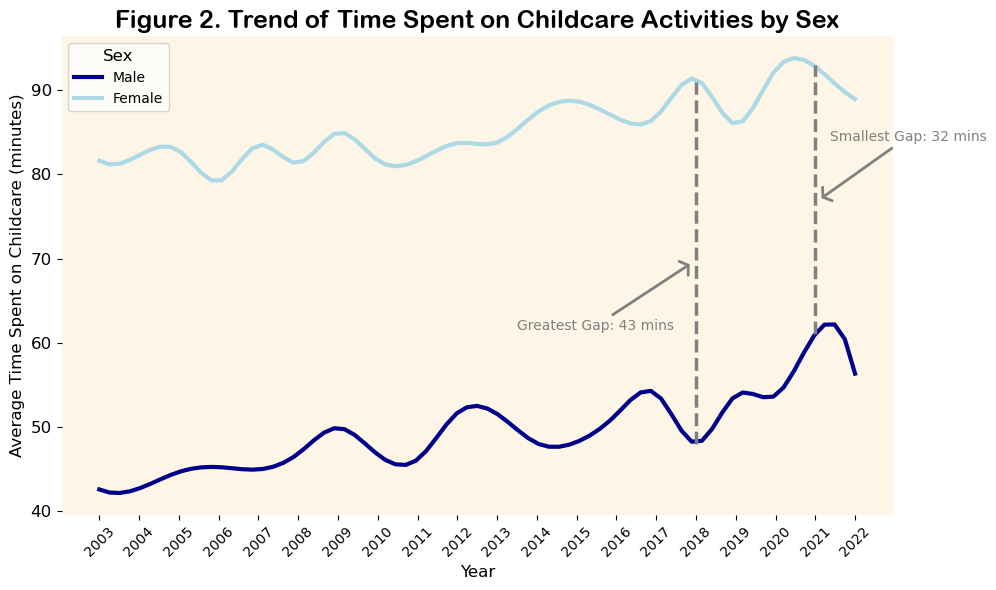

In [655]:
# Figure 2. Trend of Time Spent on Childcare Activities by Sex
# group by 'TUYEAR' and 'TESEX' and calculate the mean of 'Household Child Care'
childcare_time_by_year_sex = atus_df_mod3.groupby(['TUYEAR', 'TESEX'])['Household Child Care'].mean().unstack()

plt.figure(figsize=(10, 6))
sex_labels = {1: 'Male', 2: 'Female'}
colors = {1: 'darkblue', 2: 'lightblue'}
ax = plt.gca()
ax.set_facecolor('oldlace')

# create a smoother trendline using spline interpolation
for sex in childcare_time_by_year_sex.columns:
    x = childcare_time_by_year_sex.index.sort_values()
    y = childcare_time_by_year_sex[sex][x]
    
    X_Y_Spline = make_interp_spline(x, y)
    
    X_ = np.linspace(x.min(), x.max(), 75)
    
    Y_ = X_Y_Spline(X_)
    
    plt.plot(X_, Y_, linestyle='-', color=colors[sex], label=sex_labels[sex], linewidth=3)


# calculate the gap between the mean times for each year
time_gap = childcare_time_by_year_sex[2] - childcare_time_by_year_sex[1]
min_gap = round(time_gap.min())
min_gap_year = time_gap.idxmin()
max_gap = round(time_gap.max())
max_gap_year = time_gap.idxmax()

# get the corresponding times for females and males at min and max gap
min_gap_female_time = round(childcare_time_by_year_sex[2].loc[min_gap_year])
min_gap_male_time = round(childcare_time_by_year_sex[1].loc[min_gap_year])
max_gap_female_time = round(childcare_time_by_year_sex[2].loc[max_gap_year])
max_gap_male_time = round(childcare_time_by_year_sex[1].loc[max_gap_year])

# drawing dashed lines to connect the points of two gaps
plt.plot([min_gap_year, min_gap_year], [min_gap_male_time, min_gap_female_time], 
         '--', color='grey', lw=2.5)
plt.plot([max_gap_year, max_gap_year], [max_gap_male_time, max_gap_female_time], 
         '--', color='grey', lw=2.5)


# annotations for the smallest and greatest gap
plt.annotate(f'Smallest Gap: {min_gap} mins', 
             xy=(min_gap_year + 0.1, np.mean([min_gap_female_time, min_gap_male_time])),
             xytext=(min_gap_year + 4.3, np.mean([min_gap_female_time, min_gap_male_time]) + 7),
             textcoords='data',
             ha='right',
             color='grey',
             arrowprops=dict(facecolor='grey', color='grey',linewidth = 2, 
                             arrowstyle='->,head_width=0.6,head_length=0.4',
                             connectionstyle="arc3"))

plt.annotate(f'Greatest Gap: {max_gap} mins', 
             xy=(max_gap_year - 0.1, np.mean([max_gap_female_time, max_gap_male_time])),
             xytext=(max_gap_year - 4.5, np.mean([max_gap_female_time, max_gap_male_time]) - 8),
             textcoords='data',
             ha='left',
             color='grey',
             arrowprops=dict(facecolor='grey',color='grey', linewidth = 2, 
                             arrowstyle='->,head_width=0.6,head_length=0.4',
                             connectionstyle="arc3"))

plt.title('Figure 2. Trend of Time Spent on Childcare Activities by Sex', fontsize = 18,
          fontweight='bold', fontname='Arial Rounded MT Bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Time Spent on Childcare (minutes)', fontsize=12)
plt.legend(title="Sex", fontsize=10, title_fontsize=12)

# set the x-ticks and y-ticks with font size adjustment
plt.xticks(range(atus_df_mod3['TUYEAR'].min(), atus_df_mod3['TUYEAR'].max() + 1), 
           fontsize=10, rotation=45)
plt.yticks(fontsize=12)




for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


##### **Figure 3. Trend of Time Spent on Childcare Activities by Race**

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/2391162927.py:37: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



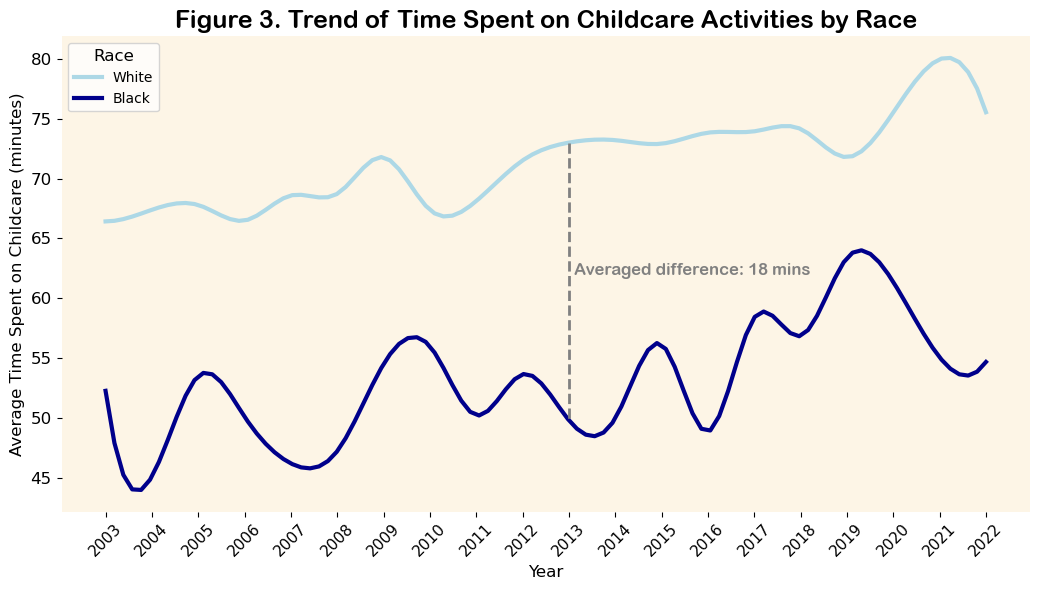

In [656]:
# Figure 3. Trend of Time Spent on Childcare Activities by Race

# include only the races of only White and Black
filtered_df = atus_df_mod3[atus_df_mod3['Race'].isin(['White', 'Black'])]

# group by 'TUYEAR' and 'Race' and calculate the mean of 'Household Child Care'
childcare_time_by_year_race = filtered_df.groupby(['TUYEAR', 'Race'])['Household Child Care'].mean().unstack()

plt.figure(figsize=(14, 6))
race_labels = {'White': 'lightblue', 'Black': 'darkblue'}
ax = plt.gca()
ax.set_facecolor('oldlace')

# create a smoother trendline using spline interpolation for each race
for race, color in race_labels.items():
    x = childcare_time_by_year_race.index.sort_values()
    y = childcare_time_by_year_race[race][x]
    
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 100)
    Y_ = X_Y_Spline(X_)
    
    plt.plot(X_, Y_, linestyle='-', color=color, label=race, linewidth=3)

# calculate means for White and Black groups
mean_white = childcare_time_by_year_race['White'].mean()  
mean_black = childcare_time_by_year_race['Black'].mean() 

y_white_2013 = childcare_time_by_year_race['White'][2013]
y_black_2013 = childcare_time_by_year_race['Black'][2013]

# calculate the rounded difference between the means
mean_difference = round(mean_white - mean_black)
arrow_year = 2013

# annotation for the mean difference
plt.plot([arrow_year, arrow_year], [y_white_2013, y_black_2013], 'k--', lw=2, color='grey')

plt.text(arrow_year + 0.1, (mean_white + mean_black) / 2, f'Averaged difference: {mean_difference} mins',
         verticalalignment='center', horizontalalignment='left', color='grey',
         fontweight='bold', fontname='Arial Rounded MT Bold',
         fontsize = 12)

plt.title('Figure 3. Trend of Time Spent on Childcare Activities by Race', 
          fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Time Spent on Childcare (minutes)', fontsize=12)
plt.legend(title='Race', fontsize=10, title_fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
plt.xticks(childcare_time_by_year_race.index, fontsize=10, rotation=45)
plt.yticks(fontsize=12)


ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout(rect=[0, 0, 0.75, 1])

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(rect=[0, 0, 0.75, 1])    
plt.grid(False)
plt.show()


##### **Figure 4. Time Spent on Household Child Care by Education Level**

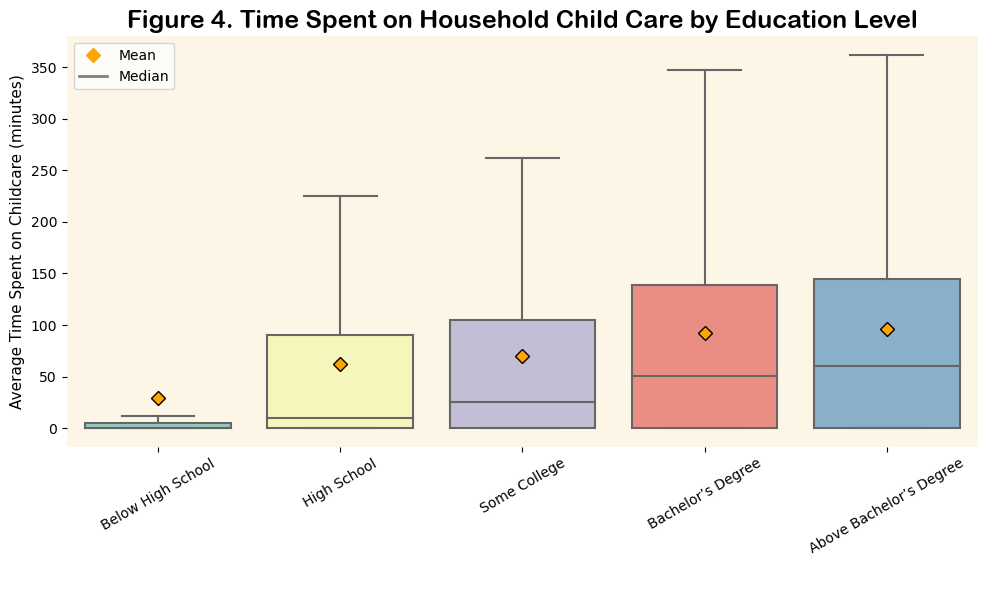

In [657]:
# Figure 4. Time Spent on Household Child Care by Education Level

# customizing the mean marker
meanprops = {"marker":"D", "markerfacecolor":"orange", 
             "markeredgecolor":"black", "markersize": 7}

# creating the boxplot
plt.figure(figsize=(10, 6))
box = sns.boxplot(x='Education (highest level achieved)', y='Household Child Care', 
                  data=atus_df_mod3, showfliers=False, showmeans=True, meanprops=meanprops, 
                  palette='Set3')

ax = plt.gca()
ax.set_facecolor('oldlace')

# customizing the plot
plt.title('Figure 4. Time Spent on Household Child Care by Education Level', 
          fontsize = 18,fontweight='bold', fontname='Arial Rounded MT Bold')
plt.xticks(rotation=30)

# creating custom legend items for mean and median
mean_legend = mlines.Line2D([], [], color='orange', marker='D', linestyle='None', markersize=7, label='Mean')
median_legend = mlines.Line2D([], [], color='gray', linestyle='-', linewidth=2, label='Median')

# combine the custom mean/median handles
handles = [mean_legend, median_legend]

# placing the combined legend on the right side and outside of the plot
plt.legend(handles=handles, title='')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xlabel(' ', fontsize=13) 
plt.ylabel('Average Time Spent on Childcare (minutes)', fontsize=11)

plt.tight_layout()
plt.show()


##### **Figure 5. Average Time Spent on Activities by Education Level**

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/2158523337.py:78: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



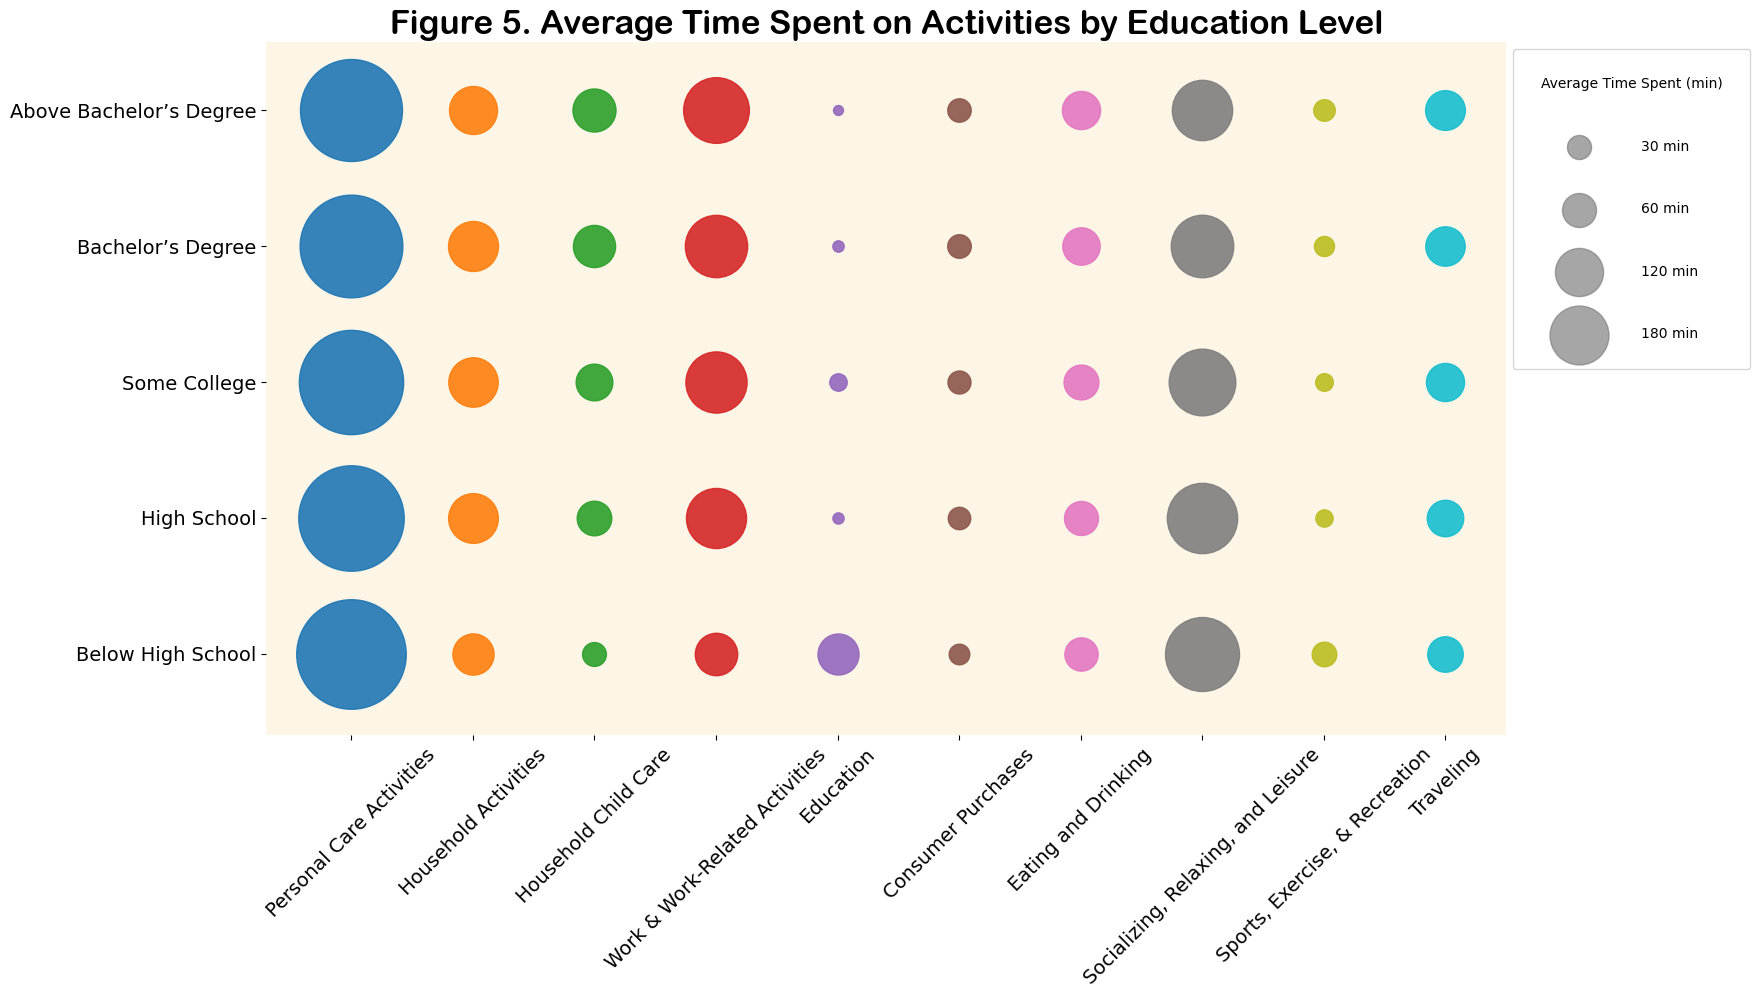

In [658]:
# Figure 5. Average Time Spent on Activities by Education Level

# define the order for education levels
education_order = [
    'Below High School', 'High School', 'Some College', 
    'Bachelor’s Degree', 'Above Bachelor’s Degree'
]

# list of activity columns
activities = [
    "Personal Care Activities", "Household Activities", 'Household Child Care',
    "Work & Work-Related Activities", "Education", "Consumer Purchases",
    "Eating and Drinking", "Socializing, Relaxing, and Leisure",
    "Sports, Exercise, & Recreation", "Traveling"
]

# group by 'Education_Level' and calculate the mean time spent on each activity
avg_activities_by_education = atus_df_mod3.groupby('Education (highest level achieved)')[activities].mean()

# define the bubble size scaling factor for both plot and legend
scaling_factor = 10

# create the bubble plot
fig, ax = plt.subplots(figsize=(16, 9))  # Increased figure size
ax = plt.gca()
ax.set_facecolor('oldlace')

# Offset to move the bubbles up
y_offset = 0.1

# iterate over the dataFrame and create scatter points
for i, education_level in enumerate(education_order):
    for j, activity in enumerate(activities):
        size = avg_activities_by_education.loc[education_level, activity] * scaling_factor
        ax.scatter(j, i + y_offset, s=size, alpha=0.9)

# set the labels for the activities on the x-axis and education levels on the y-axis
ax.set_xticks(range(len(activities)))
ax.set_xticklabels(activities, rotation=45)
ax.set_yticks([y + y_offset for y in range(len(education_order))])
ax.set_yticklabels(education_order)

# set labels and title
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Figure 5. Average Time Spent on Activities by Education Level', 
             size=24, fontweight='bold', fontname='Arial Rounded MT Bold')

# sizes and labels for the legend
example_sizes = [30, 60, 120, 180] 
size_labels = ['30 min', '60 min', '120 min', '180 min']

# handles for the legend
handles = [plt.scatter([], [], s=size * scaling_factor, alpha=0.7, 
                       color='gray') for size in example_sizes]

# create a legend with the handles and corresponding labels
legend = ax.legend(
    handles,
    size_labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Average Time Spent (min)',
    labelspacing=3.5, 
    handletextpad=3.5,  
    borderpad=2       
)


ax.set_xlim(-0.7, len(activities) - 0.5)
ax.set_ylim(-0.5, len(education_order) - 0.5 + y_offset)
ax.grid(False)


for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(rect=[0.9, 0, 0.85, 1])
plt.show()


##### **Figure 5.2. Average Time Spent on Activities by Education Level in Adult Households**

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1103859620.py:68: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



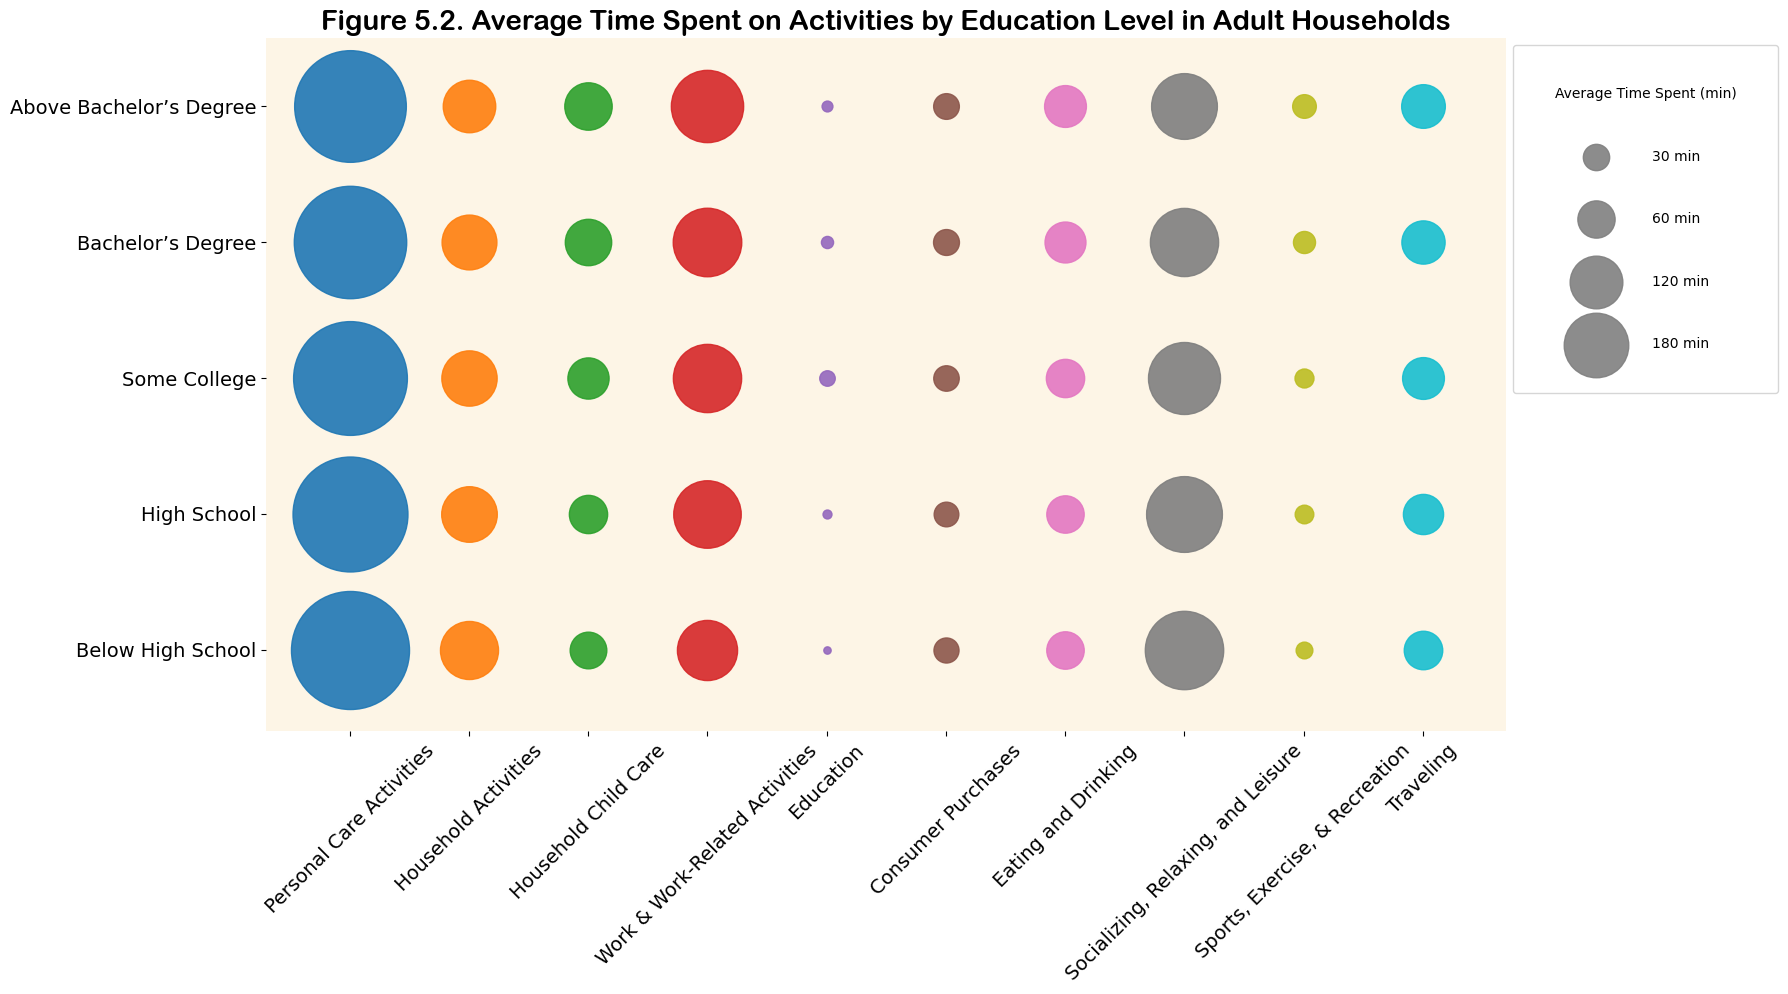

In [659]:
# Figure 5.2. Average Time Spent on Activities by Education Level in Adult Households

# restrict the sample to 'Adult' in the 'Age_Group' column
filtered_df_adult = atus_df_mod3[(atus_df_mod3['Age'] == 'Adults')]


# group by 'Education_Level' in the filtered dataframe and calculate the mean time spent on each activity
avg_activities_by_education_adult = filtered_df_adult.groupby('Education (highest level achieved)')[activities].mean()

# define the bubble size scaling factor for both plot and legend
scaling_factor = 12

# create the bubble plot
fig, ax = plt.subplots(figsize=(16, 9))
ax = plt.gca()
ax.set_facecolor('oldlace')

# Offset to move the bubbles up
y_offset = 0.1

# iterate over the DataFrame and create scatter points
for i, education_level in enumerate(education_order):
    for j, activity in enumerate(activities):
        size = avg_activities_by_education_adult.loc[education_level, activity] * scaling_factor
        ax.scatter(j, i + y_offset, s=size, alpha=0.9)

# sizes and labels for the legend
example_sizes = [30, 60, 120, 180]
size_labels = ['30 min', '60 min', '120 min', '180 min']

# handles for the legend
handles = [plt.scatter([], [], s=size * scaling_factor, alpha=0.9, color='gray') for size in example_sizes]

# set the labels for the activities on the x-axis and education levels on the y-axis
ax.set_xticks(range(len(activities)))
ax.set_xticklabels(activities, rotation=45)
ax.set_yticks([y + y_offset for y in range(len(education_order))])
ax.set_yticklabels(education_order)

# set labels and title
ax.set_title('Figure 5.2. Average Time Spent on Activities by Education Level in Adult Households', 
             size=20, fontweight='bold', fontname='Arial Rounded MT Bold')

# adjust axes and layout
ax.set_xlim(-0.7, len(activities) - 0.3 )
ax.set_ylim(-0.5, len(education_order) - 0.5 + y_offset)
ax.grid(False)

# create a legend and adjust labelspacing to increase space between bubbles
legend = ax.legend(
    handles,
    size_labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Average Time Spent (min)',
    labelspacing=3.5, 
    handletextpad=3,  
    borderpad=3       
)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# adjust layout to make space for the legend outside the plot
plt.tight_layout(rect=[0.9, 0, 0.85, 1])
plt.show()


In [660]:
# Because there are too many activites and it is difficult to view the pattern,
# we then pick the top four activities and childcare to better display

# calculate the mean time spent across all education levels for each activity
mean_time_per_activity = atus_df_mod3[activities].mean()

# sort the activities by the mean time and get the top five
top_five_activities = mean_time_per_activity.sort_values(ascending=False).head(5)

# convert to a DataFrame for better presentation
top_five_activities_df = pd.DataFrame(top_five_activities).reset_index()
top_five_activities_df.columns = ['Activity', 'Average Time Spent (minutes)']

# display the DataFrame
top_five_activities_df


Activity  Average Time Spent (minutes)
0            Personal Care Activities                    570.588565
1  Socializing, Relaxing, and Leisure                    234.495900
2      Work & Work-Related Activities                    179.532416
3                Household Activities                    119.573830
4                           Traveling                     74.116655

##### **Figure 5.3. Average Time Spent on Top Five Activities by Education Level (Proportion)**

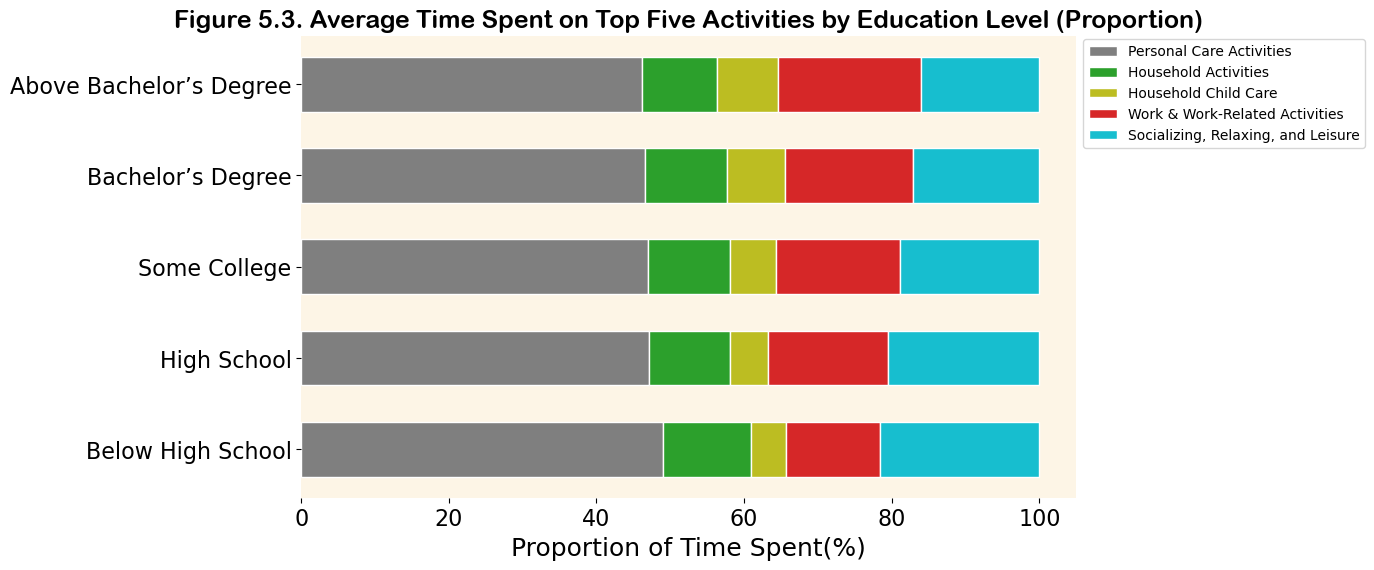

In [661]:
# Figure 5.3. Average Time Spent on Top Five Activities by Education Level (Proportion)

# redefine the activities for the plot
activities = [
    "Personal Care Activities", "Household Activities", 'Household Child Care',
    "Work & Work-Related Activities",  "Socializing, Relaxing, and Leisure"]


# group by 'Education_Level' and calculate the mean time spent on each activity
avg_activities_by_education_adult = filtered_df_adult.groupby('Education (highest level achieved)')[activities].mean()

# reordering the data according to the education order
avg_activities_by_education_adult = avg_activities_by_education_adult.reindex(education_order)

# convert the absolute values to proportions
totals = avg_activities_by_education_adult.sum(axis=1)  
avg_activities_by_education_proportion_adult = avg_activities_by_education_adult.div(totals, axis=0) * 100

# plotting stacked bar chart with proportions
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(education_order))
ax = plt.gca()
ax.set_facecolor('oldlace')

# a color scheme of red, lighter red, and grey
colors = ['#7f7f7f', '#2ca02c', '#bcbd22', '#d62728', '#17becf']

# add a stack for each activity and keep track of the left starting point
lefts = np.zeros(len(education_order))

# plot each activity with the respective color
for i, activity in enumerate(activities):
    ax.barh(indices, avg_activities_by_education_proportion_adult[activity], 
            color=colors[i % len(colors)], edgecolor='white', height=bar_width, 
            left=lefts, label=activity)
    lefts += avg_activities_by_education_proportion_adult[activity].values

# set the y ticks to be the education levels
ax.set_yticks(indices)
ax.set_yticklabels(education_order)

# add the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.875))

# title and labels
ax.set_title('Figure 5.3. Average Time Spent on Top Five Activities by Education Level (Proportion)'
             , fontsize = 18,fontweight='bold', fontname='Arial Rounded MT Bold')
ax.set_xlabel('Proportion of Time Spent(%)', fontsize = 18)

# show the plot
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)    

ax.grid(False)    
plt.show()


##### **Figure 6. Average Time Spent on Childcare Activities by Education Level in Adult Households**

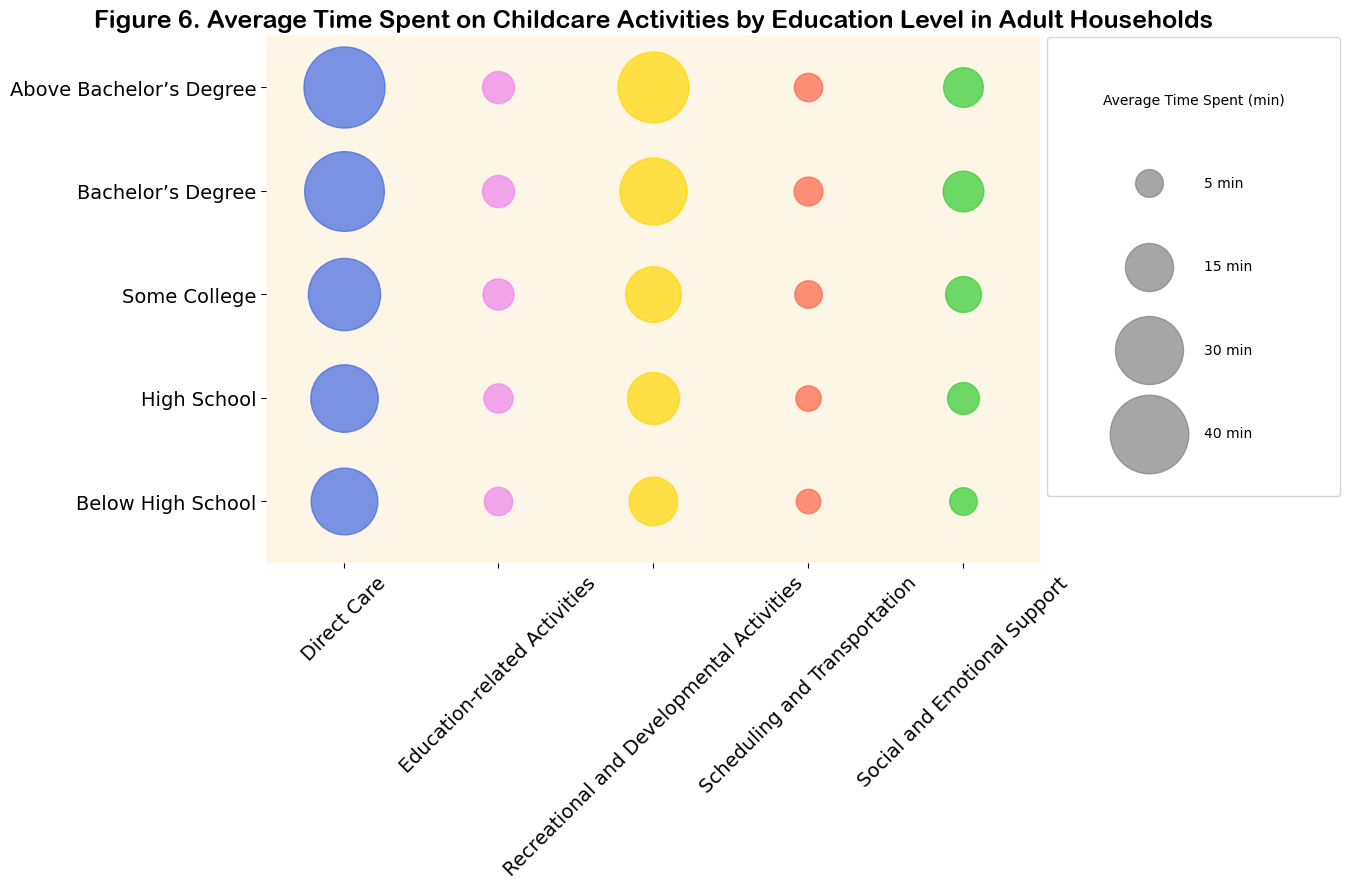

In [662]:
# Figure 6. Average Time Spent on Childcare Activities by Education Level in Adult Households

# further restrict the sample to 'Adult' in the 'Age_Group' column
filtered_df_adult_c = atus_df_child[(atus_df_child['Age'] == 'Adults')]

# list of childcare activity
childcare_activities = [
    "Direct Care", 
    "Education-related Activities", 
    "Recreational and Developmental Activities", 
    "Scheduling and Transportation", 
    "Social and Emotional Support"
]

# define a color for each childcare activity
colors = {
    "Direct Care": "royalblue",
    "Social and Emotional Support": "limegreen",
    "Scheduling and Transportation": "tomato",
    "Recreational and Developmental Activities": "gold",
    "Education-related Activities": "violet"
}

# group by 'Education (highest level achieved)' in the filtered dataframe and calculate the mean time spent on each childcare activity
avg_childcare_activities_by_education_adult = filtered_df_adult_c.groupby('Education (highest level achieved)')[childcare_activities].mean()

# define the bubble size scaling 
scaling_factor = 80

# create the bubble plot
fig, ax = plt.subplots(figsize=(16, 9))
ax = plt.gca()
ax.set_facecolor('oldlace')

# offset to move the bubbles up
y_offset = 0.1

# iterate over the DataFrame and create scatter points for childcare activities
for i, education_level in enumerate(education_order):
    for j, activity in enumerate(childcare_activities):
        size = avg_childcare_activities_by_education_adult.loc[education_level, activity] * scaling_factor
        ax.scatter(j, i + y_offset, s=size, alpha=0.7, color=colors[activity])

# sizes and labels for the legend
example_sizes = [5, 15, 30, 40] 
size_labels = ['5 min', '15 min', '30 min', '40 min']

# handles for the legend
legend_handles = [plt.scatter([], [], s=size * scaling_factor, alpha=0.7, color='gray') for size in example_sizes]

# set the labels for childcare activities on the x-axis and education levels on the y-axis
ax.set_xticks(range(len(childcare_activities)))
ax.set_xticklabels(childcare_activities, rotation=45)
ax.set_yticks([y + y_offset for y in range(len(education_order))])
ax.set_yticklabels(education_order)

# set labels and title to reflect the focus on childcare activities
ax.set_title('Figure 6. Average Time Spent on Childcare Activities by Education Level in Adult Households', 
             fontsize = 18,fontweight='bold', fontname='Arial Rounded MT Bold')

# adjust axes and layout
ax.set_xlim(-0.5, len(childcare_activities) - 0.5)
ax.set_ylim(-0.5, len(education_order) - 0.5 + y_offset)
ax.grid(False)

# create a legend with the dummy handles and corresponding labels
legend = ax.legend(
    legend_handles,
    size_labels,
    loc='upper left',
    bbox_to_anchor=(1, 1.01),
    title='Average Time Spent (min)',
    labelspacing=5,
    handletextpad=3,
    borderpad=4
)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)         

# adjust layout to make space for the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


##### **Figure 6.2. Average Time Spent on Childcare Activities by Education Level**

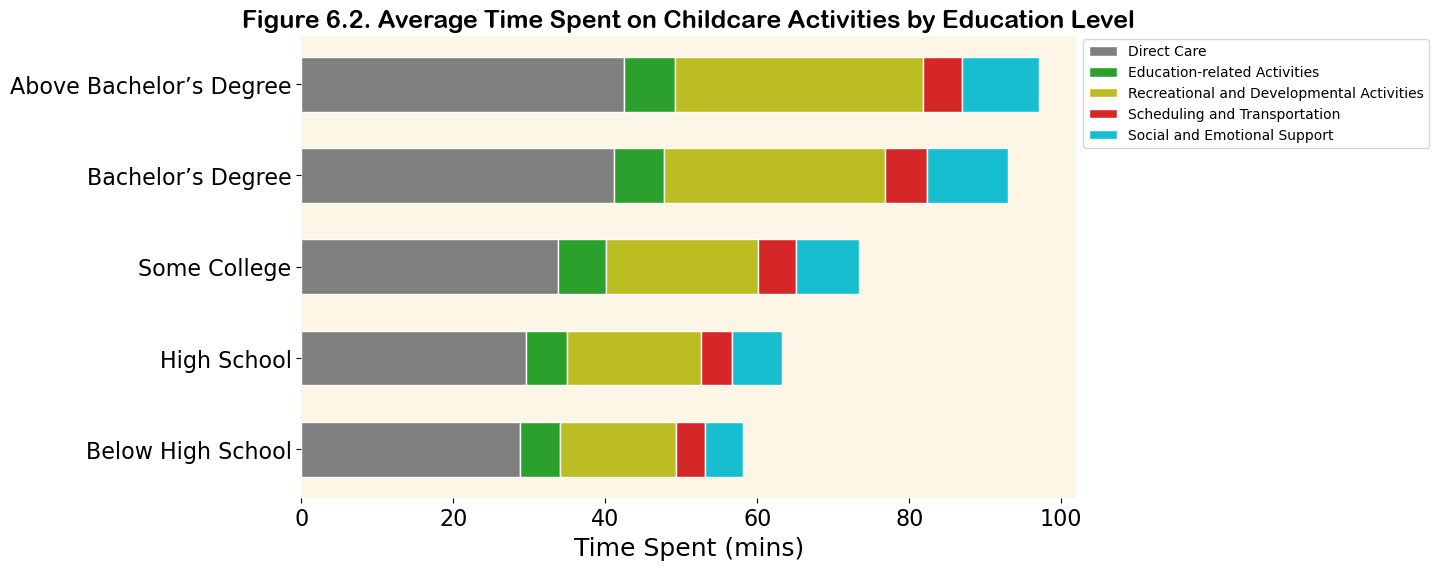

In [663]:
# Figure 6.2. Average Time Spent on Childcare Activities by Education Level

# reordering the data according to the education order
avg_activities_by_education_adult = filtered_df_adult_c.groupby('Education (highest level achieved)')[childcare_activities].mean()
avg_activities_by_education_adult = avg_activities_by_education_adult.reindex(education_order)

# plotting the data as absolute values
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(education_order))
ax.set_facecolor('oldlace')

colors = ['#7f7f7f', '#2ca02c', '#bcbd22', '#d62728', '#17becf']

# adding stacks for each activity
for i, activity in enumerate(childcare_activities):
    ax.barh(indices, avg_activities_by_education_adult[activity], 
            color=colors[i % len(colors)], edgecolor='white', height=bar_width, 
            left=avg_activities_by_education_adult[childcare_activities[:i]].sum(axis=1),
            label=activity)

ax.set_yticks(indices)
ax.set_yticklabels(education_order)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.875))

ax.set_title('Figure 6.2. Average Time Spent on Childcare Activities by Education Level', 
             fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
ax.set_xlabel('Time Spent (mins)', fontsize=18)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.grid(False)
plt.show()

##### **Figure 6.3. Average Time Spent on Childcare Activities by Education Level(Proportion)**

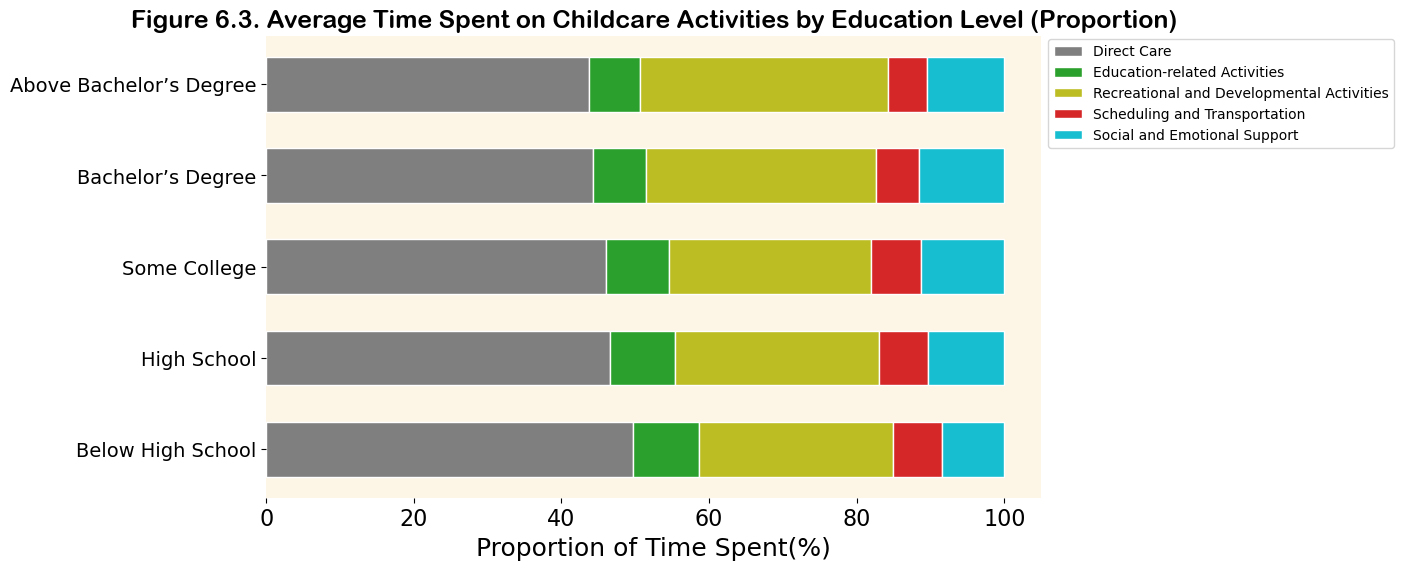

In [664]:
# Figure 6.3. Average Time Spent on Childcare Activities by Education Level (Proportion)


# group by 'Education (highest level achieved)' and calculate the mean time spent on each activity
avg_activities_by_education_adult = filtered_df_adult_c.groupby('Education (highest level achieved)')[childcare_activities].mean()

# reordering the data according to the education order
avg_activities_by_education_adult = avg_activities_by_education_adult.reindex(education_order)

# convert the absolute values to proportions
totals = avg_activities_by_education_adult.sum(axis=1)
avg_activities_by_education_proportion_adult = avg_activities_by_education_adult.div(totals, axis=0) * 100

# plotting stacked bar chart with proportions
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(education_order))
ax.set_facecolor('oldlace')

# add a stack for each activity
for i, activity in enumerate(childcare_activities):
    ax.barh(indices, avg_activities_by_education_proportion_adult[activity], 
            color=colors[i % len(colors)], edgecolor='white', height=bar_width, 
            left=avg_activities_by_education_proportion_adult[childcare_activities[:i]].sum(axis=1),
            label=activity)

# set the y ticks to be the education levels
ax.set_yticks(indices)
ax.set_yticklabels(education_order)

# add the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.875))

# title and labels
ax.set_title('Figure 6.3. Average Time Spent on Childcare Activities by Education Level (Proportion)', 
             fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
ax.set_xlabel('Proportion of Time Spent(%)', fontsize=18)

# Show the plot
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=14)

ax.grid(False)
plt.show()

##### **Figure 7. Average Time Spent on Childcare Activities by Age of Children**

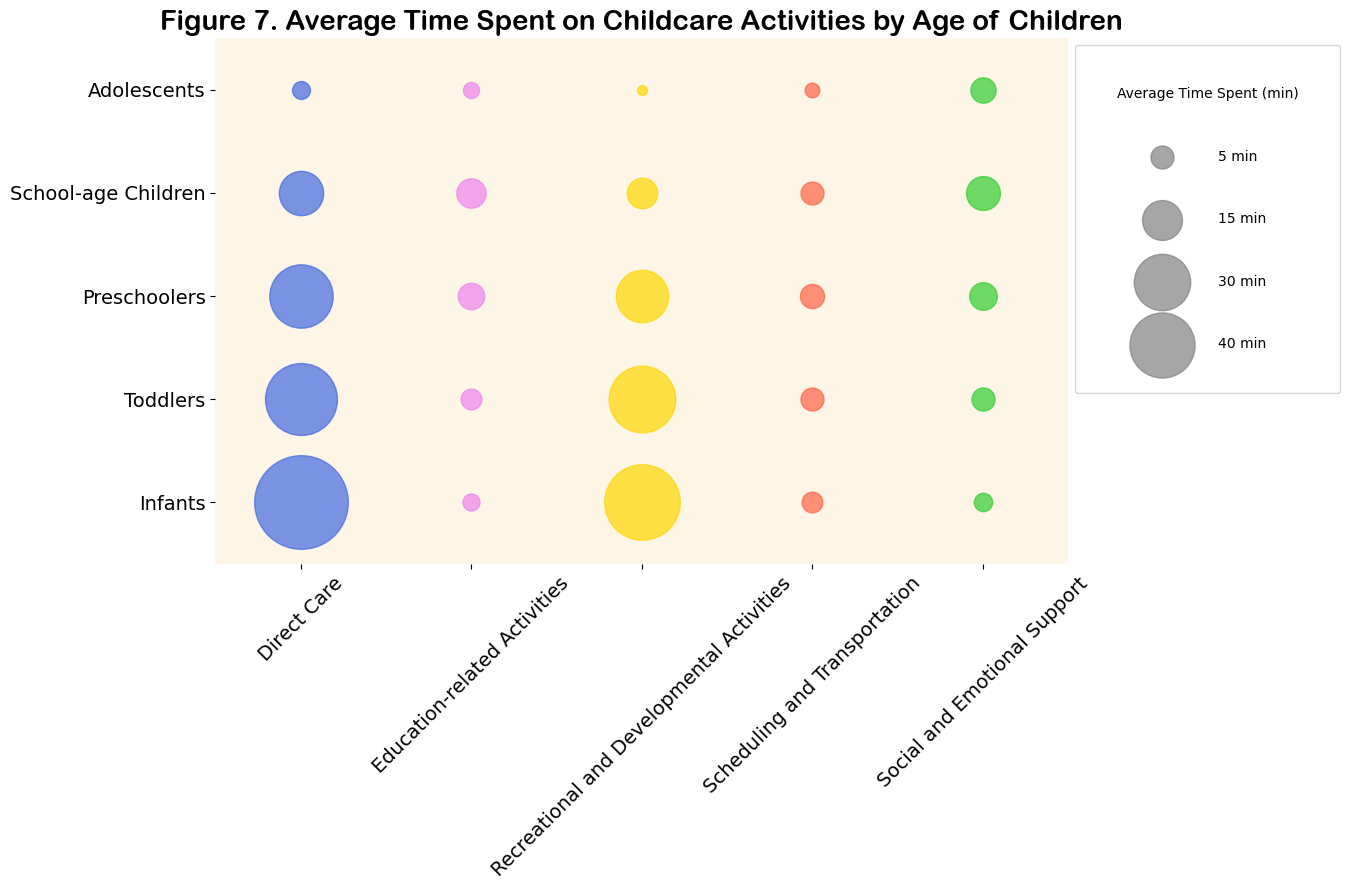

In [665]:
# Figure 7. Average Time Spent on Childcare Activities by Age of Children

# define the order for children's age categories
children_age_order = ['Infants', 'Toddlers', 'Preschoolers', 'School-age Children', 'Adolescents']


# redefine a color for each childcare activity
colors = {
    "Direct Care": "royalblue",
    "Social and Emotional Support": "limegreen",
    "Scheduling and Transportation": "tomato",
    "Recreational and Developmental Activities": "gold",
    "Education-related Activities": "violet"
}

# Group by 'Age (Children)' in the filtered dataframe and calculate the mean time spent on each childcare activity
avg_childcare_activities_by_children_age = atus_df_child.groupby('Age (Children)')[childcare_activities].mean()

# define the bubble size scaling factor for both plot and legend
scaling_factor = 55

# create the bubble plot 
fig, ax = plt.subplots(figsize=(16, 9))
ax = plt.gca()
ax.set_facecolor('oldlace')

# offset to move the bubbles up
y_offset = 0.1

# iterate over the dataFrame and create scatter points for childcare activities
for i, age_category in enumerate(children_age_order):
    for j, activity in enumerate(childcare_activities):
        size = avg_childcare_activities_by_children_age.loc[age_category, activity] * scaling_factor
        ax.scatter(j, i + y_offset, s=size, alpha=0.7, color=colors[activity])

# sizes and labels for the legend
example_sizes = [5, 15, 30, 40] 
size_labels = ['5 min', '15 min', '30 min', '40 min']

# create handles for the legend
legend_handles = [plt.scatter([], [], s=size * scaling_factor, alpha=0.7, color='gray') for size in example_sizes]

# set the labels for childcare activities on the x-axis and children's age categories on the y-axis
ax.set_xticks(range(len(childcare_activities)))
ax.set_xticklabels(childcare_activities, rotation=45)
ax.set_yticks([y + y_offset for y in range(len(children_age_order))])
ax.set_yticklabels(children_age_order)

# set labels and title to reflect the focus on childcare activities by children's age
ax.set_title('Figure 7. Average Time Spent on Childcare Activities by Age of Children', 
             fontsize = 20,fontweight='bold', fontname='Arial Rounded MT Bold')

# adjust axes and layout
ax.set_xlim(-0.5, len(childcare_activities) - 0.5)
ax.set_ylim(-0.5, len(children_age_order) - 0.5 + y_offset)
ax.grid(False)

# create a legend
legend = ax.legend(
    legend_handles,
    size_labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Average Time Spent (min)',
    labelspacing=3.5,
    handletextpad=3,
    borderpad=3
)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)       

# adjust layout to make space for the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


##### **Figure 7.2. Average Time Spent on Childcare Activities by Child Age**

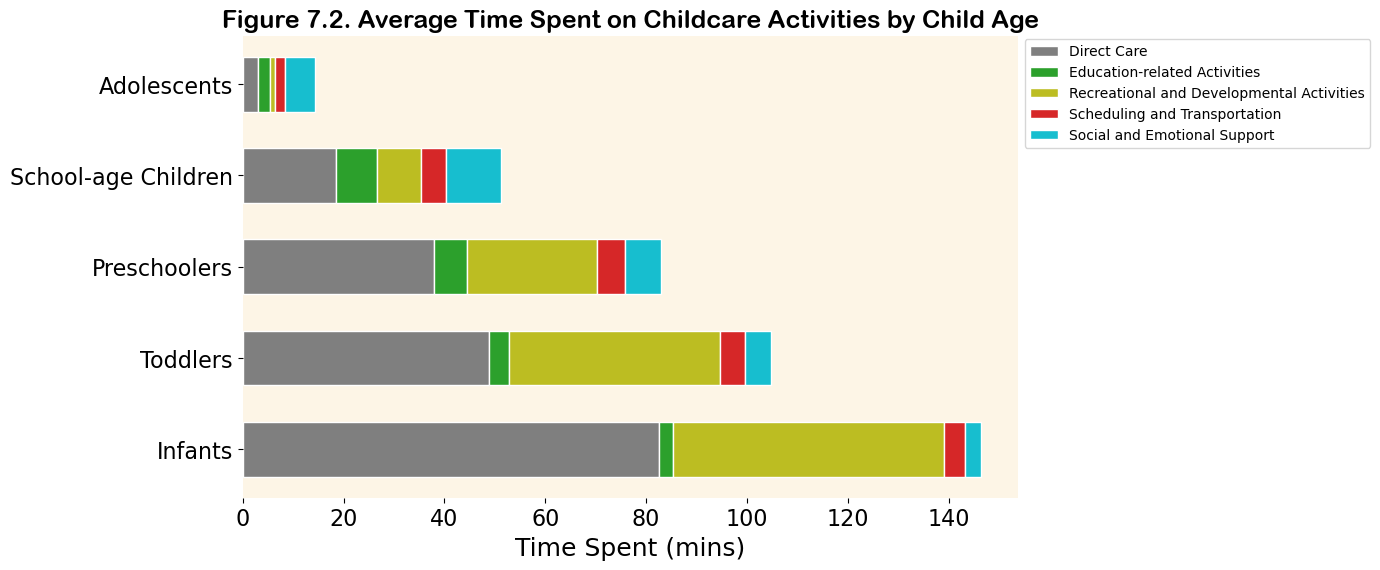

In [666]:
# Figure 7.2. Average Time Spent on Childcare Activities by Child Age

# group by 'Age (Children)' and calculate the mean time spent on each activity
avg_activities_by_children_age = atus_df_child.groupby('Age (Children)')[childcare_activities].mean()


# plotting the data as absolute values
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(children_age_order))
ax.set_facecolor('oldlace')

colors = ['#7f7f7f', '#2ca02c', '#bcbd22', '#d62728', '#17becf']

# adding stacks for each activity
for i, activity in enumerate(childcare_activities):
    ax.barh(indices, avg_activities_by_children_age[activity], 
            color=colors[i % len(colors)], edgecolor='white', height=bar_width, 
            left=avg_activities_by_children_age[childcare_activities[:i]].sum(axis=1),
            label=activity)

ax.set_yticks(indices)
ax.set_yticklabels(children_age_order)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.875))

ax.set_title('Figure 7.2. Average Time Spent on Childcare Activities by Child Age', fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
ax.set_xlabel('Time Spent (mins)', fontsize=18)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.grid(False)

plt.show()

##### **Figure 7.3. Average Time Spent on Childcare Activities by Child Age (Proportion)**

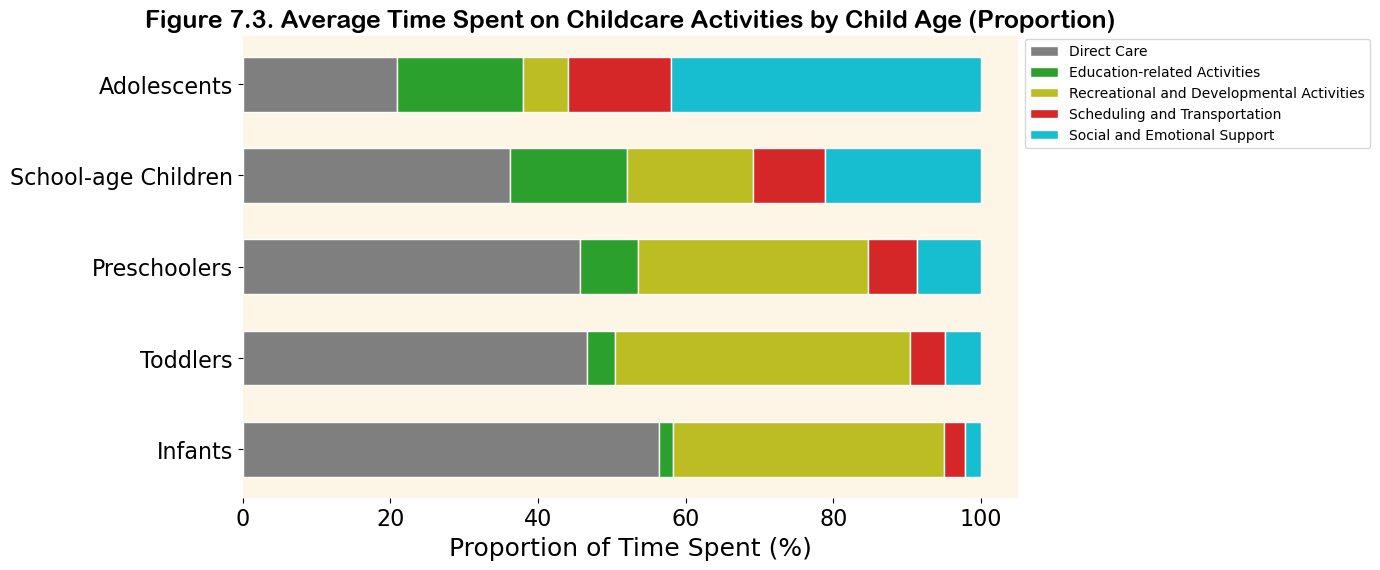

In [667]:
# Figure 7.3. Average Time Spent on Childcare Activities by Child Age (Proportion)


# group by 'Age (Children)' and calculate the mean time spent on each activity
avg_activities_by_children_age = atus_df_child.groupby('Age (Children)')[childcare_activities].mean()


# convert the absolute values to proportions
totals = avg_activities_by_children_age.sum(axis=1) 
avg_activities_by_children_age_proportion = avg_activities_by_children_age.div(totals, axis=0) * 100

# plotting stacked bar chart with proportions
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(children_age_order))
ax.set_facecolor('oldlace')

# add a stack for each activity
for i, activity in enumerate(childcare_activities):
    ax.barh(indices, avg_activities_by_children_age_proportion[activity], 
            color=colors[i % len(colors)], edgecolor='white', height=bar_width, 
            left=avg_activities_by_children_age_proportion[childcare_activities[:i]].sum(axis=1),
            label=activity)

# set the y ticks to be the children's age categories
ax.set_yticks(indices)
ax.set_yticklabels(children_age_order)

# add the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.875))

# title and labels
ax.set_title('Figure 7.3. Average Time Spent on Childcare Activities by Child Age (Proportion)', 
             fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
ax.set_xlabel('Proportion of Time Spent (%)', fontsize=18)

# show the plot
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.grid(False)
plt.show()

#### **Part 6. Modelling**

##### **Part 6.1. OLS Regression Model**
- We first examine the effects of socioeconomic and demogrpahic variables on time spent on childcare

In [668]:
# selecting only the relevant columns for the model, including the continuous 'Household Child Care'
columns_of_interest = ['Race', 'Sex', 'Employment Status', 'Education (highest level achieved)', 
                       'Number of Children in Household', 'Age (Children)', 'Age', 'Household Child Care']

# subset the DataFrame to keep only the columns of interest
atus_df_mod3_model = atus_df_mod3[columns_of_interest]

# convert categorical variables to dummy variables
atus_df_mod3_dummies = pd.get_dummies(atus_df_mod3_model, drop_first=True)

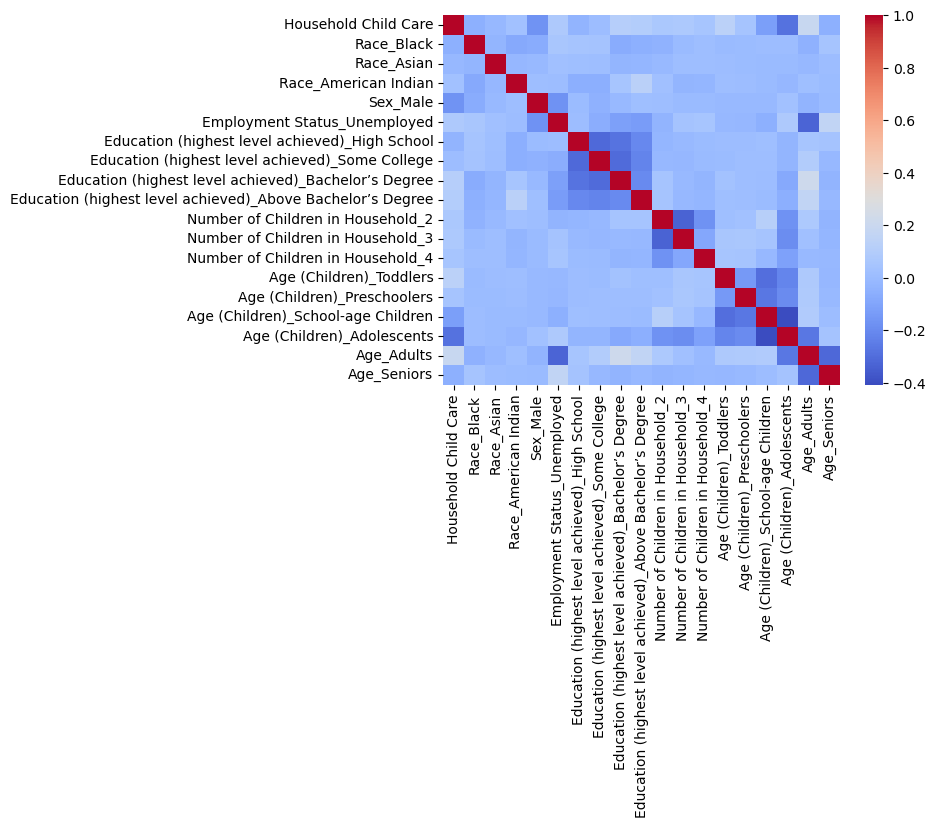

In [669]:
# check for Multicollinearity
corr_matrix = atus_df_mod3_dummies.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

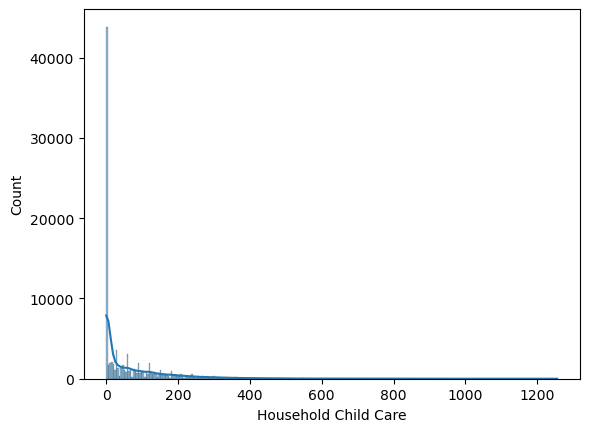

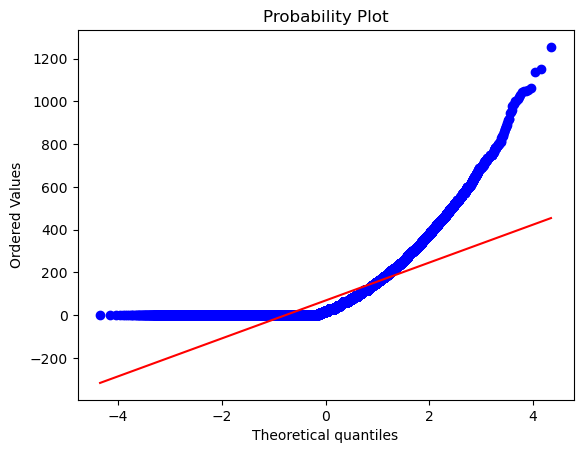

In [670]:
# check normality of the dependent variable
sns.histplot(atus_df_mod3_dummies['Household Child Care'], kde=True)
plt.show()

stats.probplot(atus_df_mod3_dummies['Household Child Care'], dist="norm", plot=plt)
plt.show()

In [671]:
# define the dependent variable
Y = atus_df_mod3_dummies['Household Child Care']

# define the independent variables
X = atus_df_mod3_dummies.drop('Household Child Care', axis=1)

# adding a constant to the model (intercept)
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# print out the statistics
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     Household Child Care   R-squared:                       0.247
Model:                              OLS   Adj. R-squared:                  0.247
Method:                   Least Squares   F-statistic:                     1814.
Date:                  Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                          15:21:34   Log-Likelihood:            -5.9206e+05
No. Observations:                 99627   AIC:                         1.184e+06
Df Residuals:                     99608   BIC:                         1.184e+06
Df Model:                            18                                         
Covariance Type:              nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [672]:
# create a summary table for displaying the results of the model

# define the reference group
reference_categories = {
    'Race': 'White',
    'Sex': 'Female',
    'Age': 'Youth',
    'Age (Children)': 'Infants',
    'Number of Children in Household': '1',
    'Education (highest level achieved)': 'Below High School',
    'Employment Status': 'Employed'
}

# define significance markers
significance_markers = {
    '***': 0.001,
    '**': 0.01,
    '*': 0.05,
    '†': 0.1
}

# create the results DataFrame
results_df = pd.DataFrame({
    'coef': model.params,
    'p_value': model.pvalues,
    'conf_lower': model.conf_int().loc[:, 0],
    'conf_higher': model.conf_int().loc[:, 1]
}, index=X.columns)

# initialize the formatted results  with 'Intercept' as the first variable
formatted_results = pd.DataFrame({
    'Variable': ['Intercept'],
    'Category': [''],
    'Coef': [f"{model.params['const']:.3f}***"], 
    '[95% CI]': [f"[{model.conf_int().loc['const', 0]:.3f}, {model.conf_int().loc['const', 1]:.3f}]"]
})

# function to determine the significance marker
def get_significance_marker(p_value):
    """
    Determine the significance marker based on the p-value.

    Parameters:
    - p_value (float): The p-value obtained from statistical testing.

    Returns:
    - str: Significance marker indicating the level of significance ('*', '**', '***', or '').
    """
    for marker, threshold in significance_markers.items():
        if p_value < threshold:
            return marker
    return ''

# iterate over the results DataFrame and populate the formatted results
for index, row in results_df.iterrows():
    if index == 'const': 
        continue

    variable_name = ' '.join(index.split('_')[:-1])
    category = index.split('_')[-1] if '_' in index else ''
    ref_category = reference_categories.get(variable_name, 'N/A')
    
    if variable_name not in formatted_results['Variable'].values:
        formatted_results = formatted_results.append({
            'Variable': '', 'Category': '', 'Coef': '', '[95% CI]': ''
        }, ignore_index=True)
        formatted_results = formatted_results.append({
            'Variable': variable_name,
            'Category': f"(reference: {ref_category})",
            'Coef': '',
            '[95% CI]': ''
        }, ignore_index=True)
        
    significance_marker = get_significance_marker(row['p_value'])
    formatted_results = formatted_results.append({
        'Variable': '',
        'Category': category,
        'Coef': f"{row['coef']:.3f}{significance_marker}",
        '[95% CI]': f"[{row['conf_lower']:.3f}, {row['conf_higher']:.3f}]"
    }, ignore_index=True)

# add R-squared and number of observations at the end of the DataFrame
formatted_results = formatted_results.append({
    'Variable': '', 'Category': '', 'Coef': '', '[95% CI]': ''
}, ignore_index=True)
formatted_results = formatted_results.append({
    'Variable': 'Model N', 'Category': '', 'Coef': f"{int(model.nobs)}", '[95% CI]': ''
}, ignore_index=True)
formatted_results = formatted_results.append({
    'Variable': 'Model R²', 'Category': '', 'Coef': f"{model.rsquared:.3f}", '[95% CI]': ''
}, ignore_index=True)

# apply styling to the DataFrame
styles = [
    dict(selector="th", props=[("text-align", "left")]),
    dict(selector="td", props=[("text-align", "left")]),
    dict(selector=".row_heading", props=[("display", "none")]),
    dict(selector=".blank.level0", props=[("display", "none")]),
    dict(selector=".data", props=[("font-weight", "normal")]),
    dict(selector=".index_name", props=[("display", "none")])
]
styled_df = (formatted_results.style
    .set_table_styles(styles)
    .hide_index()
    .applymap(lambda x: 'font-weight: bold', subset=['Variable', 'Coef', '[95% CI]'])
    .set_properties(**{'text-align': 'left', 'font-weight': ''}, subset=['Category'])
)

styled_df

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1896128423.py:64: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1896128423.py:67: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1896128423.py:75: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1896128423.py:75: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/1896128423.py:75: FutureWarning:

The frame.append method is de

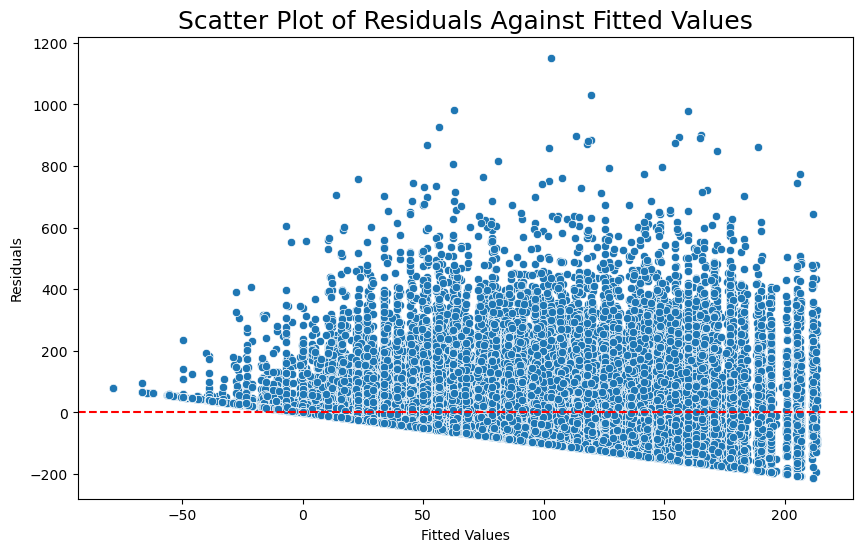

Breusch-Pagan Test Statistic: 4953.047517441616, p-value: 0.0


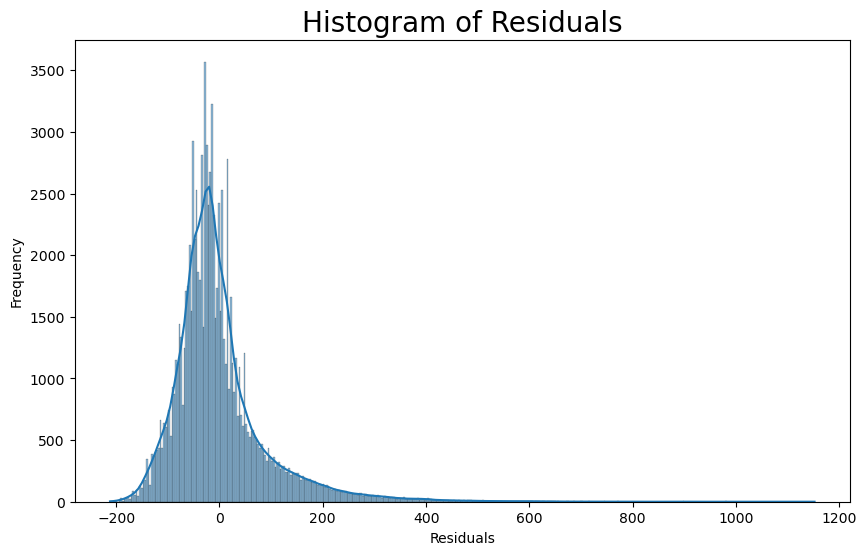

Shapiro-Wilk Test Statistic: 0.8432974815368652, p-value: 0.0


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



In [673]:
# after building the model, we notice the r-squared value is low
# based on the previous result of non-normality of the variables, we further check
# the residuals and found that model's errors are not spread out evenly and 
# do not follow the expected bell curve pattern. 
# Instead, they are skewed to one side and have extreme values

# Extract residuals
residuals = model.resid

# Homoscedasticity Checks

# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.title('Scatter Plot of Residuals Against Fitted Values', size = 18)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)    
plt.show()

## Breusch-Pagan Test
bp_test = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")

# Normality Checks of Residuals
# histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals', size = 20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False) 
ax.set_title('Figure 7.3. Average Time Spent on Childcare Activities by Child Age (Proportion)', 
             fontsize=18, fontweight='bold', fontname='Arial Rounded MT Bold')
plt.show()

## Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")


##### **Part 6.2. Zero-Inflated Negative Binomial (ZINB) model**

- We use Zero-Inflated Negative Binomial (ZINB) model for the following reasons:
    1. the model is robust against data that follows a normal distribution
    2. time spent on childcare is highly clustered around zero minutes
        - because we have parents that are below the age of 18 and over the age of 64
        - becase some parents may not care for children during the time of survey
        - the selected model specifically is designed for the conditions above

In [674]:
# check the proportion of the childcare time that is zero
proportion_zero = (atus_df_mod3['Household Child Care'] == 0).mean()
print(proportion_zero)

0.42378070201852913


In [675]:
# given that there are two versions of Zero-Inflated models, we first try both of
# them with our data

# fit a Zero-Inflated Poisson (ZIP) model
zip_model = ZeroInflatedPoisson(endog=Y, exog=X, exog_infl=X, inflation='logit').fit()
print("Zero-Inflated Poisson Model Summary:")
print(zip_model.summary())

# fit a Zero-Inflated Negative Binomial (ZINB) model
zinb_model = ZeroInflatedNegativeBinomialP(endog=Y, exog=X, exog_infl=X, inflation='logit').fit()
print("Zero-Inflated Negative Binomial Model Summary:")
print(zinb_model.summary())

         Current function value: 24.996718
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Zero-Inflated Poisson Model Summary:
                     ZeroInflatedPoisson Regression Results                     
Dep. Variable:     Household Child Care   No. Observations:                99627
Model:              ZeroInflatedPoisson   Df Residuals:                    99608
Method:                             MLE   Df Model:                           18
Date:                  Mon, 04 Mar 2024   Pseudo R-squ.:                  0.1781
Time:                          15:21:40   Log-Likelihood:            -2.4903e+06
converged:                        False   LL-Null:                   -3.0300e+06
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
inflate_const                                

/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Zero-Inflated Negative Binomial Model Summary:


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning:

invalid value encountered in log



                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:              Household Child Care   No. Observations:                99627
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    99608
Method:                                      MLE   Df Model:                           18
Date:                           Mon, 04 Mar 2024   Pseudo R-squ.:                 0.05229
Time:                                   15:22:34   Log-Likelihood:            -3.7884e+05
converged:                                 False   LL-Null:                   -3.9974e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
inflate_co

In [676]:
# Since the r-squared values are low and significantly differernt from both models,
# we check the residuals and BIC for the fit of the model

# Calculate the Pearson residuals
pearson_residuals = zip_model.resid_pearson

# Calculate the Pearson chi2 statistic
pearson_chi2 = np.sum(pearson_residuals**2)

# Compute the ratio of Pearson chi2 to the degrees of freedom

# If this ratio is significantly greater than 1, it indicates overdispersion
# meaning ZINB is more approriate
overdispersion_ratio = pearson_chi2 / zip_model.df_resid
print('Overdispersion ratio:', overdispersion_ratio)


Overdispersion ratio: 4.057846167844208


In [677]:
# Get AIC and BIC for ZIP model
zip_aic = zip_model.aic
zip_bic = zip_model.bic

# Get AIC and BIC for ZINB model
zinb_aic = zinb_model.aic
zinb_bic = zinb_model.bic

# Compare the AIC values
print('ZIP AIC:', zip_aic)
print('ZINB AIC:', zinb_aic)

# Compare the BIC values
print('ZIP BIC:', zip_bic)
print('ZINB BIC:', zinb_bic)

ZIP AIC: 4980772.147234074
ZINB AIC: 757748.3094017716
ZIP BIC: 4981133.496396738
ZINB BIC: 758119.1677529274


##### **Part 6.3. Zero-Inflated Negative Binomial (ZINB) model (adults only)**
- Given that the models above are performing poorly and not converging, we suspect that the input data may not be approriate.
- Hence, we restrict the data to adult households only, because parents who are younger than the age of 18 or older than the age of 64 may not relevant to detect the education effects.

In [454]:
# selecting only the relevant columns for the model, including the continuous 'Household Child Care'
columns_of_interest = ['Race', 'Sex', 'Employment Status', 'Education (highest level achieved)',
                       'Number of Children in Household', 'Age (Children)', 'Household Child Care']  # 'Age' is removed here

# subset the DataFrame to keep only the columns of interest
atus_df_mod3_model = filtered_df_adult[columns_of_interest]

# convert categorical variables to dummy variables
atus_df_mod3_dummies = pd.get_dummies(atus_df_mod3_model, drop_first=True)


Y = atus_df_mod3_dummies['Household Child Care']
X = atus_df_mod3_dummies.drop('Household Child Care', axis=1)

# adding a constant to the model (intercept)
X = sm.add_constant(X)


# fit a Zero-Inflated Poisson (ZIP) model
zip_model = ZeroInflatedPoisson(endog=Y, exog=X, exog_infl=X, inflation='logit').fit()
print("Zero-Inflated Poisson Model Summary:")
print(zip_model.summary())


# fit a Zero-Inflated Negative Binomial (ZINB) model
zinb_model = ZeroInflatedNegativeBinomialP(endog=Y, exog=X, exog_infl=X, inflation='logit').fit()
print("Zero-Inflated Negative Binomial Model Summary:")
print(zinb_model.summary())

         Current function value: 28.025582
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Zero-Inflated Poisson Model Summary:
                     ZeroInflatedPoisson Regression Results                     
Dep. Variable:     Household Child Care   No. Observations:                81844
Model:              ZeroInflatedPoisson   Df Residuals:                    81827
Method:                             MLE   Df Model:                           16
Date:                  Mon, 04 Mar 2024   Pseudo R-squ.:                  0.1762
Time:                          13:35:26   Log-Likelihood:            -2.2937e+06
converged:                        False   LL-Null:                   -2.7844e+06
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
inflate_const                                

/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Zero-Inflated Negative Binomial Model Summary:
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:              Household Child Care   No. Observations:                81844
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    81827
Method:                                      MLE   Df Model:                           16
Date:                           Mon, 04 Mar 2024   Pseudo R-squ.:                 0.03424
Time:                                   13:36:05   Log-Likelihood:            -3.4932e+05
converged:                                 False   LL-Null:                   -3.6170e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

##### **Part 6.4. Zero-Inflated Negative Binomial (ZINB) model (boostrap)**
- After restricting the sample to adults only, the models still perform poorly
- Finally, we used boostrap to handle the issue of imbalance for some of the independent variables
- However, the performance reamins poorly for both models

In [100]:
# Number of bootstrap samples
n_bootstraps = 100

def fit_model(data, results_zip, results_zinb):
    """
    Fit Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB) models to the data.

    Parameters:
    - data (DataFrame): The DataFrame containing the data for modeling.
    - results_zip (list): List to store the summary information of the ZIP model.
    - results_zinb (list): List to store the summary information of the ZINB model.

    Returns:
    None
    """
    
    Y = data['Household Child Care']
    X = data.drop('Household Child Care', axis=1)
    X = sm.add_constant(X)

    # fit the Zero-Inflated Poisson (ZIP) model
    zip_model = ZeroInflatedPoisson(endog=Y, exog=X, exog_infl=X, inflation='logit').fit(disp=0)
    zip_summary = {
        'params': zip_model.params,
        'std_err': zip_model.bse,
        'z': zip_model.tvalues,
        'P>|z|': zip_model.pvalues,
        'conf_int': zip_model.conf_int(),
        'Pseudo R-squ': zip_model.prsquared,
        'Log-Likelihood': zip_model.llf,
        'LL-Null': zip_model.llnull,
        'LLR p-value': zip_model.llr_pvalue
    }
    results_zip.append(zip_summary)

    # fit the Zero-Inflated Negative Binomial (ZINB) model
    zinb_model = ZeroInflatedNegativeBinomialP(endog=Y, exog=X, exog_infl=X, inflation='logit').fit(disp=0)
    zinb_summary = {
        'params': zinb_model.params,
        'std_err': zinb_model.bse,
        'z': zinb_model.tvalues,
        'P>|z|': zinb_model.pvalues,
        'conf_int': zinb_model.conf_int(),
        'Pseudo R-squ': zinb_model.prsquared,
        'Log-Likelihood': zinb_model.llf,
        'LL-Null': zinb_model.llnull,
        'LLR p-value': zinb_model.llr_pvalue
    }
    results_zinb.append(zinb_summary)

# initialize the lists to store results
bootstrap_results_zip = []
bootstrap_results_zinb = []

# perform bootstrapping
for i in range(n_bootstraps):
    bootstrapped_df = resample(atus_df_mod3_dummies, replace=True, n_samples=len(atus_df_mod3_dummies))
    fit_model(bootstrapped_df, bootstrap_results_zip, bootstrap_results_zinb)

# convert results to DataFrame for further analysis (for coefficients only)
bootstrap_results_zip_df = pd.DataFrame([x['params'] for x in bootstrap_results_zip])
bootstrap_results_zinb_df = pd.DataFrame([x['params'] for x in bootstrap_results_zinb])

# print out Pseudo R-squared values for the first model of each type as an example
print("Pseudo R-squared for the first ZIP model:", bootstrap_results_zip[0]['Pseudo R-squ'])
print("Pseudo R-squared for the first ZINB model:", bootstrap_results_zinb[0]['Pseudo R-squ'])


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/st

Pseudo R-squared for the first ZIP model: 0.17480774294697954
Pseudo R-squared for the first ZINB model: 0.034417322427119146


In [455]:
model_summary = bootstrap_results_zinb[0]

# define the reference categories for the main and inflated effects
main_reference_categories = {
    'Race': 'White',
    'Sex': 'Female',
    'Age': 'Youth',
    'Age (Children)': 'Infants',
    'Number of Children in Household': '1',
    'Education (highest level achieved)': 'Below High School',
    'Employment Status': 'Employed'
}

inflate_reference_categories = {
    'inflate Race': 'White',
    'inflate Sex': 'Female',
    'infate Age': 'Youth',
    'inflate Employment Status': 'Employed',
    'inflate Age (Children)': 'Infants',
    'inflate Education (highest level achieved)': 'Below High School',
    'inflate Number of Children in Household': '1'
}

significance_markers = {
    '***': 0.001,
    '**': 0.01,
    '*': 0.05,
    '†': 0.1
}

# create a DataFrame from the model params and other statistics
results_df = pd.DataFrame({
    'coef': model_summary['params'],
    'p_value': model_summary['P>|z|'],
    'conf_lower': model_summary['conf_int'][0],
    'conf_higher': model_summary['conf_int'][1]
}, index=model_summary['params'].index)

# initialize the formatted results DataFrame
formatted_results = pd.DataFrame(columns=['Variable', 'Category', 'Coef', '[95% CI]'])

# function to determine the significance marker
def get_significance_marker(p_value):
    """
    Determine the significance marker based on the p-value.

    Parameters:
    - p_value (float): The p-value obtained from statistical testing.

    Returns:
    - str: Significance marker indicating the level of significance ('*', '**', '***', or '').
    """    
    for marker, threshold in significance_markers.items():
        if p_value <= threshold:
            return marker
    return ''

# function to append formatted results
def append_formatted_results(formatted_results, variable_name, category, row, ref_category):
    """
    Append formatted results to a DataFrame.

    Parameters:
    - formatted_results (DataFrame): DataFrame containing formatted results.
    - variable_name (str): Name of the variable being analyzed.
    - category (str): Category of the variable.
    - row (dict): Dictionary containing coefficient, p-value, and confidence intervals.
    - ref_category (str): Reference category for the variable.

    Returns:
    - DataFrame: DataFrame with the appended formatted results.
    """
    formatted_results = formatted_results.append({
        'Variable': variable_name,
        'Category': f"(reference: {ref_category})" if variable_name else category,
        'Coef': f"{row['coef']:.3f}{get_significance_marker(row['p_value'])}",
        '[95% CI]': f"[{row['conf_lower']:.3f}, {row['conf_higher']:.3f}]"
    }, ignore_index=True)
    return formatted_results

# iterate over the results DataFrame and populate the formatted results
for index, row in results_df.iterrows():
    parts = index.split('_')
    inflate = 'inflate' in parts[0]
    variable_name = ' '.join(parts[:-1]) if inflate else parts[0] if len(parts) == 1 else ' '.join(parts[:-1])
    category = parts[-1] if len(parts) > 1 else ''
    ref_category = inflate_reference_categories.get(variable_name, 'N/A') if inflate else main_reference_categories.get(variable_name, 'N/A')

    if index == 'const':
        formatted_results = append_formatted_results(formatted_results, 'Intercept', '', row, ref_category)
    else:
        if variable_name not in formatted_results['Variable'].values:
            formatted_results = append_formatted_results(formatted_results, variable_name, category, row, ref_category)
        formatted_results = append_formatted_results(formatted_results, '', category, row, '')

# add model diagnostics at the end
diagnostics = [
    {'Variable': 'Model Diagnostics', 'Category': '', 'Coef': '', '[95% CI]': ''},
    {'Variable': 'Pseudo R²', 'Category': '', 'Coef': f"{model_summary['Pseudo R-squ']:.3f}", '[95% CI]': ''},
    {'Variable': 'Log-Likelihood', 'Category': '', 'Coef': f"{model_summary['Log-Likelihood']:.3f}", '[95% CI]': ''},
    {'Variable': 'LLR p-value', 'Category': '', 'Coef': f"{model_summary['LLR p-value']:.3f}", '[95% CI]': ''}
]

for diag in diagnostics:
    formatted_results = formatted_results.append(diag, ignore_index=True)

# styling 
styles = [
    dict(selector="th", props=[("text-align", "left")]),
    dict(selector="td", props=[("text-align", "left")]),
    dict(selector=".row_heading", props=[("display", "none")]),
    dict(selector=".blank.level0", props=[("display", "none")]),
    dict(selector=".data", props=[("font-weight", "normal")]),
    dict(selector=".index_name", props=[("display", "none")])
]

styled_df = (formatted_results.style
    .set_table_styles(styles)
    .hide_index()
    .applymap(lambda x: 'font-weight: bold', subset=['Variable', 'Coef', '[95% CI]'])
    .set_properties(**{'text-align': 'left', 'font-weight': ''}, subset=['Category']))

styled_df     

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/4204197864.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/4204197864.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/4204197864.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/4204197864.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_10558/4204197864.py:73: FutureWarning:

The frame.append method is de

##### **Part 6.5. OLS Regression Model with Interaction Terms**

In [678]:
# first, create a dictionary mapping the FIPS codes to state names
fips_to_state = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan", 27: "Minnesota",
    28: "Mississippi", 29: "Missouri", 30: "Montana", 31: "Nebraska", 32: "Nevada",
    33: "New Hampshire", 34: "New Jersey", 35: "New Mexico", 36: "New York",
    37: "North Carolina", 38: "North Dakota", 39: "Ohio", 40: "Oklahoma",
    41: "Oregon", 42: "Pennsylvania", 44: "Rhode Island", 45: "South Carolina",
    46: "South Dakota", 47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont",
    51: "Virginia", 53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming"
}



# mapping FIPS codes to state names
atus_df_mod3['StateName'] = atus_df_mod3['STATEFIP'].map(fips_to_state)
atus_df_mod3['StateName'].head

<bound method NDFrame.head of 1          California
3             Georgia
4            Kentucky
5            Kentucky
6           Louisiana
             ...     
236565    Connecticut
236566           Utah
236570        Indiana
236583        Alabama
236586       New York
Name: StateName, Length: 99627, dtype: object>

In [679]:
# calculate the mean of 'Household Child Care' grouped by 'StateName'
state_child_care_avg = atus_df_mod3.groupby('StateName')['Household Child Care'].mean().reset_index().round()

# rename the columns to match the format
state_child_care_avg.columns = ['State', 'Average Time Spent with Children']

# calculate the total number of samples (which represents our sample population)
total_samples = atus_df_mod3['StateName'].count()

# calculate the count of samples for each state to represent the sample population proportion
state_sample_counts = atus_df_mod3['StateName'].value_counts().reset_index()
state_sample_counts.columns = ['State', 'SampleCount']

# merge to include the sample counts with the average time spent
state_child_care_avg = pd.merge(state_child_care_avg, state_sample_counts, on='State')

# calculate the percentage of population for each state based on sample proportion
state_child_care_avg['Population Percentage'] = (state_child_care_avg['SampleCount'] / total_samples * 100).round(2)

# drop the 'SampleCount' column as it's no longer needed
state_child_care_avg.drop('SampleCount', axis=1, inplace=True)


# sort the DataFrame by 'Population Percentage' in descending order
state_child_care_avg_sorted = state_child_care_avg.sort_values(by='Population Percentage', ascending=False)

state_child_care_avg_sorted

State  Average Time Spent with Children  \
4             California                              66.0   
43                 Texas                              63.0   
32              New York                              76.0   
9                Florida                              66.0   
13              Illinois                              73.0   
38          Pennsylvania                              73.0   
35                  Ohio                              72.0   
22              Michigan                              71.0   
33        North Carolina                              68.0   
46              Virginia                              74.0   
30            New Jersey                              75.0   
10               Georgia                              64.0   
47            Washington                              74.0   
23             Minnesota                              72.0   
14               Indiana                              68.0   
21         Massachusetts                              80.0   
49             Wisconsin                              70.0   
25              Missouri                              70.0   
42             Tennessee                              72.0   
5               Colorado                              70.0   
2                Arizona                              61.0   
20              Maryland                              68.0   
17              Kentucky                              69.0   
37                Oregon                              66.0   
0                Alabama                              65.0   
40        South Carolina                              59.0   
15                  Iowa                              72.0   
36              Oklahoma                              63.0   
44                  Utah                              66.0   
18             Louisiana                              62.0   
6            Connecticut                              77.0   
16                Kansas                              72.0   
3               Arkansas                              65.0   
24           Mississippi                              54.0   
28                Nevada                              64.0   
27              Nebraska                              71.0   
31            New Mexico                              58.0   
12                 Idaho                              62.0   
48         West Virginia                              77.0   
29         New Hampshire                              73.0   
19                 Maine                              75.0   
39          Rhode Island                              72.0   
26               Montana                              65.0   
41          South Dakota                              72.0   
7               Delaware                              70.0   
34          North Dakota                              62.0   
11                Hawaii                              63.0   
50               Wyoming                              51.0   
45               Vermont                              81.0   
1                 Alaska                              69.0   
8   District of Columbia                              91.0   

    Population Percentage  
4                   10.37  
43                   7.53  
32                   5.16  
9                    4.70  
13                   4.15  
38                   4.07  
35                   3.79  
22                   3.51  
33                   3.00  
46                   2.97  
30                   2.88  
10                   2.82  
47                   2.37  
23                   2.35  
14                   2.32  
21                   2.29  
49                   2.24  
25                   2.13  
42                   2.05  
5                    1.94  
2                    1.90  
20                   1.86  
17                   1.77  
37                   1.53  
0                    1.52  
40                   1.49  
15                   1.40  
36        

In [680]:
# Load GeoJSON data
with open('us-states.json') as f:
    geojson = json.load(f)

# Exclude Puerto Rico from the GeoJSON data
geojson['features'] = [feature for feature in geojson['features'] if feature['properties']['name'] != 'Puerto Rico']

# create a choropleth map
fig = px.choropleth(state_child_care_avg, 
                    geojson=geojson, 
                    locations='State',  
                    featureidkey="properties.name", 
                    color='Average Time Spent with Children', 
                    color_continuous_scale="amp",  
                    scope="usa",
                    labels={'Average Time Spent with Children':'Average Time Spent on Childcare'})

fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},  
    title={
        'text': "Average Time Spent on Childcare by State",
        'y':0.9,  
        'x':0.5,  
        'xanchor': 'center', 
        'yanchor': 'top'  
    }
)
fig.show()


In [681]:
# group by 'NAME' and calculate mean of 'Avg medium income'
state_income_avg = state_income.groupby('NAME')['Avg medium income'].mean().reset_index().round()

# rename the columns to match the format needed for the map
state_income_avg.columns = ['State', 'Average Median Income']

# create a choropleth map 
fig = px.choropleth(state_income_avg,  
                    geojson=geojson, 
                    locations='State',  
                    featureidkey="properties.name",  
                    color='Average Median Income', 
                    color_continuous_scale="amp", 
                    scope="usa",
                    labels={'Average Median Income':'Average Median Income'})


fig.update_geos(fitbounds="locations", visible=False)  
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0},
                  title={
                      'text': "Average Median Income by State",
                      'y': 0.95, 
                      'x':0.5, 
                      'xanchor': 'center',
                      'yanchor': 'top'  
                  })

# show the figure
fig.show()


In [682]:
# build the model for the effect of income level on childcare time
state_income.rename(columns={'NAME': 'StateName'}, inplace=True)
atus_df_mod3 = atus_df_mod3.merge(state_income[['StateName', 'Avg medium income']], 
                                  on='StateName')

# Create dummy variables for each state
state_dummies = pd.get_dummies(atus_df_mod3['StateName'])
atus_df_mod3 = pd.concat([atus_df_mod3, state_dummies], axis=1)

# Dynamically create the formula, ensuring state names are properly formatted.
interaction_terms = ' + '.join([f'Q("Avg medium income")*Q("{state}")' for state in state_dummies.columns])
formula = f'Q("Household Child Care") ~ Q("Avg medium income") + {interaction_terms}'

# Fit the model.
model = smf.ols(formula=formula, data=atus_df_mod3).fit()

In [683]:
# Extract the interaction effects for the states
interaction_effects = model.params.filter(like='Q("Avg medium income"):')

# Clean up the state names from the index
state_names = interaction_effects.index.str.extract(r'Q\("Avg medium income"\):Q\("(.*?)"\)')[0]

# Create a DataFrame for mapping states to their interaction effects
interaction_effects_df = pd.DataFrame({
    'State': state_names,
    'Interaction_Effect': interaction_effects.values
})

# Create a choropleth map
fig = px.choropleth(interaction_effects_df, 
                    geojson=geojson, 
                    locations='State',  
                    featureidkey="properties.name",  
                    color='Interaction_Effect', 
                    color_continuous_scale='RdYlBu',
                    scope="usa",
                    labels={'Interaction_Effect': 'Effect of Income on Childcare Time'})


fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  title_text="Effect of Income on Childcare Time by State")

# Show the figure
fig.show()


##### **Part 6.6. OLS Regression Model at aggregate level**

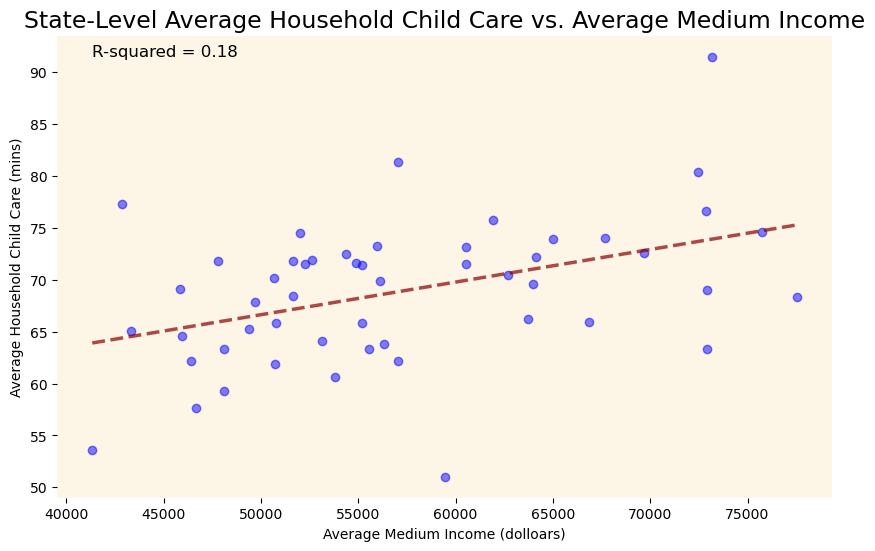

In [684]:
# plotting a scatter plot for the model
state_level_aggregates = atus_df_mod3.groupby('StateName').agg({
    'Avg medium income': 'mean',
    'Household Child Care': 'mean' 
}).reset_index()

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(state_level_aggregates['Avg medium income'], 
                                                         state_level_aggregates['Household Child Care'])

# Generate x-values 
line_x = np.array([state_level_aggregates['Avg medium income'].min(), 
                   state_level_aggregates['Avg medium income'].max()])

# Calculate the y-values 
line_y = slope * line_x + intercept

# Plotting the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6
indices = np.arange(len(children_age_order))
ax.set_facecolor('oldlace')
plt.scatter(state_level_aggregates['Avg medium income'],
             state_level_aggregates['Household Child Care'], color='blue', alpha=0.5)

# Plotting the trendline
plt.plot(line_x, line_y, color='darkred', linewidth=2.5, linestyle = 'dashed', alpha = 0.7)

# Annotating the R-squared value on the plot
plt.text(x=min(state_level_aggregates['Avg medium income']),
         y=max(state_level_aggregates['Household Child Care']),
         s=f'R-squared = {r_value**2:.2f}',
         fontsize=12)

# Setting the title and labels
plt.title('State-Level Average Household Child Care vs. Average Medium Income', size = 17)
plt.xlabel('Average Medium Income (dolloars)')
plt.ylabel('Average Household Child Care (mins)')
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

In [685]:
# OLS Regression Model at aggregate level

# Independent variable (predictor): 'Avg medium income' with a constant added for the intercept
X = sm.add_constant(state_level_aggregates['Avg medium income'])

# Dependent variable (response): 'Household Child Care'
y = state_level_aggregates['Household Child Care']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model to see the results
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Household Child Care   R-squared:                       0.181
Model:                              OLS   Adj. R-squared:                  0.164
Method:                   Least Squares   F-statistic:                     10.82
Date:                  Mon, 04 Mar 2024   Prob (F-statistic):            0.00186
Time:                          15:22:47   Log-Likelihood:                -165.70
No. Observations:                    51   AIC:                             335.4
Df Residuals:                        49   BIC:                             339.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             